# Weather Data Analysis 

### Let's import flow data.csv file and see what information it contains 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import calendar
import matplotlib.dates as mdates



In [2]:
flow_data = pd.read_csv('flow data.csv')
flow_data.head(5)

﻿Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)
ID      PARAM Date       Value                                                SYM                       
02HC027 1     1966/07/04 0.357                                                NaN                       
              1966/07/05 0.249                                                NaN                       
              1966/07/06 0.275                                                NaN                       
              1966/07/07 0.337                                                NaN

### It looks like first row of the csv changes the structure of the dataframe (Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)). Hence, we should drop it when downloading. 

In [3]:
flow_data = pd.read_csv('flow data.csv', skiprows=1)


In [4]:
flow_data.head(5)

ID  PARAM        Date  Value  SYM
0  02HC027      1  1966/07/04  0.357  NaN
1  02HC027      1  1966/07/05  0.249  NaN
2  02HC027      1  1966/07/06  0.275  NaN
3  02HC027      1  1966/07/07  0.337  NaN
4  02HC027      1  1966/07/08  0.252  NaN

### Now we will create two new dataframes each for daily discharge and for daily water level and merge them 

In [5]:
# Create separate DataFrames for PARAM = 1 and PARAM = 2 
param_1_data = flow_data[flow_data["PARAM"] == 1][["ID", "Date", "Value"]].rename(columns={"Value": "daily_discharge"})
param_2_data = flow_data[flow_data["PARAM"] == 2][["ID", "Date", "Value"]].rename(columns={"Value": "water_level"})

# Merge the two DataFrames on ID and Date
flow_data_merged = pd.merge(param_1_data, param_2_data, on=["ID", "Date"], how="outer")

# Verify the merged DataFrame
print(flow_data_merged)


            ID        Date  daily_discharge  water_level
0      02HC027  1966/07/04            0.357          NaN
1      02HC027  1966/07/05            0.249          NaN
2      02HC027  1966/07/06            0.275          NaN
3      02HC027  1966/07/07            0.337          NaN
4      02HC027  1966/07/08            0.252          NaN
...        ...         ...              ...          ...
43002  02HC024  2022/12/27            2.280       12.141
43003  02HC024  2022/12/28            2.150       12.134
43004  02HC024  2022/12/29            2.490       12.151
43005  02HC024  2022/12/30            4.920       12.249
43006  02HC024  2022/12/31           26.400       12.767

[43007 rows x 4 columns]


In [6]:
flow_data_merged.describe()

daily_discharge   water_level
count     43007.000000  15623.000000
mean          2.504642      6.147701
std           4.108611      5.907381
min           0.042000      0.199000
25%           0.370000      0.341000
50%           1.550000      0.855000
75%           2.700000     12.166000
max         108.000000     13.541000

In [7]:
# Convert the 'Date' column to datetime format
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])
flow_data_merged = flow_data_merged.sort_values(by="Date").reset_index(drop=True)


# Verify the changes
print(flow_data_merged.info())  # Confirm that the 'Date' column is now datetime
print(flow_data_merged.head())  # Inspect the first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43007 entries, 0 to 43006
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               43007 non-null  object        
 1   Date             43007 non-null  datetime64[ns]
 2   daily_discharge  43007 non-null  float64       
 3   water_level      15623 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.3+ MB
None
        ID       Date  daily_discharge  water_level
0  02HC024 1962-10-01             2.15          NaN
1  02HC024 1962-10-02             1.98          NaN
2  02HC024 1962-10-03             1.87          NaN
3  02HC024 1962-10-04             1.87          NaN
4  02HC024 1962-10-05             6.37          NaN


In [8]:
# Filter rows where water_level is not null
water_level_available = flow_data_merged[flow_data_merged["water_level"].notnull()]

# Find the minimum and maximum dates
min_date = water_level_available["Date"].min()
max_date = water_level_available["Date"].max()

# Print the range
print(f"Water level is available from {min_date} to {max_date}.")

Water level is available from 2002-01-01 00:00:00 to 2023-12-31 00:00:00.


### The Water level measuremnts only available from 2002-01-01 till 2023-12-31. Hence, we will constrain the data to these dates

In [9]:
start_date = "2002-01-01"
end_date = "2023-12-31"

# Filter the DataFrame to only include rows within the specified range
flow_data_merged = flow_data_merged[(flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)]
flow_data_merged = flow_data_merged.sort_values(by="Date").reset_index(drop=True)

# Verify the filtered DataFrame
print(flow_data_merged)

            ID       Date  daily_discharge  water_level
0      02HC024 2002-01-01            1.560       12.114
1      02HC027 2002-01-01            0.193        0.263
2      02HC024 2002-01-02            1.490       12.108
3      02HC027 2002-01-02            0.186        0.305
4      02HC027 2002-01-03            0.185        0.252
...        ...        ...              ...          ...
15700  02HC027 2023-12-27            3.790        0.693
15701  02HC027 2023-12-28            1.830        0.680
15702  02HC027 2023-12-29            1.850        0.622
15703  02HC027 2023-12-30            1.310        0.575
15704  02HC027 2023-12-31            0.630        0.401

[15705 rows x 4 columns]


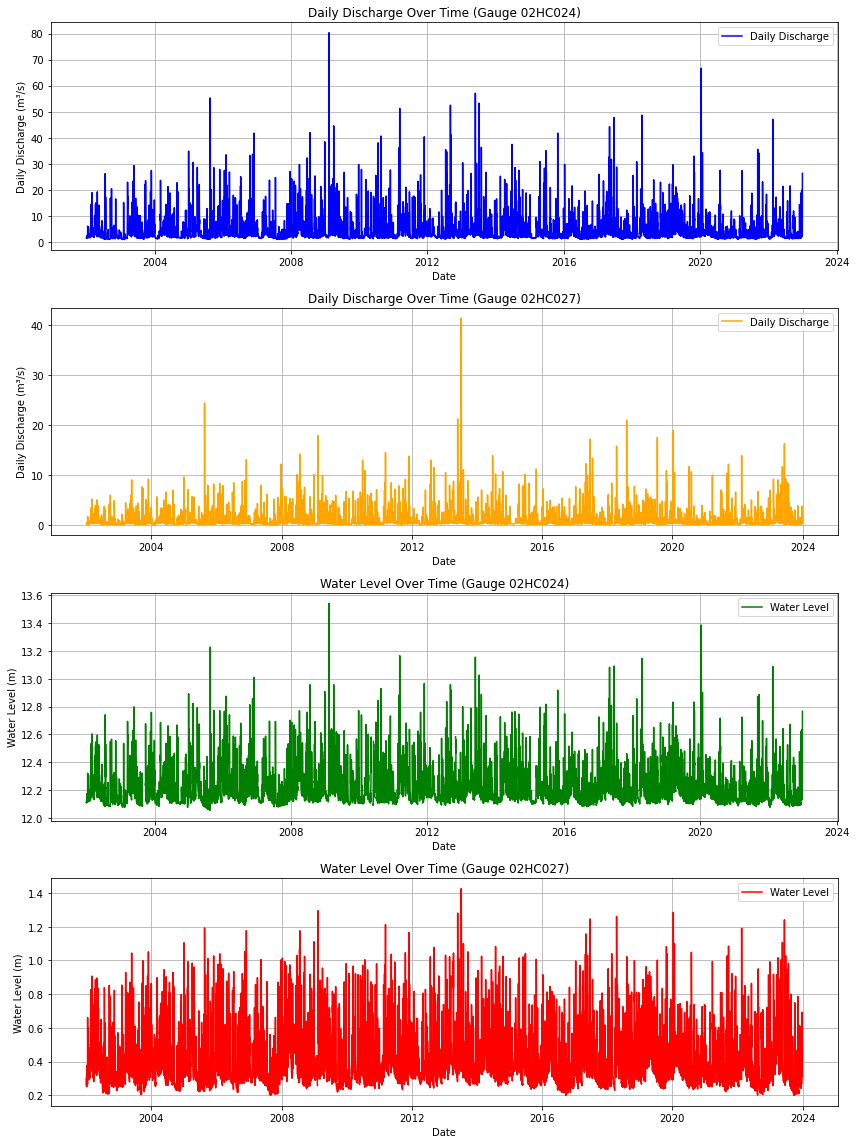

In [10]:
# Filter data for each gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

plt.figure(figsize=(12, 16))

# Subplot 1: Daily Discharge for Gauge 02HC024
plt.subplot(4, 1, 1)
plt.plot(gauge_1_data["Date"], gauge_1_data["daily_discharge"], label="Daily Discharge", color="blue")
plt.xlabel("Date")
plt.ylabel("Daily Discharge (m³/s)")
plt.title("Daily Discharge Over Time (Gauge 02HC024)")
plt.grid(True)
plt.legend()

# Subplot 2: Daily Discharge for Gauge 02HC027
plt.subplot(4, 1, 2)
plt.plot(gauge_2_data["Date"], gauge_2_data["daily_discharge"], label="Daily Discharge", color="orange")
plt.xlabel("Date")
plt.ylabel("Daily Discharge (m³/s)")
plt.title("Daily Discharge Over Time (Gauge 02HC027)")
plt.grid(True)
plt.legend()

# Subplot 3: Water Level for Gauge 02HC024
plt.subplot(4, 1, 3)
plt.plot(gauge_1_data["Date"], gauge_1_data["water_level"], label="Water Level", color="green")
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Water Level Over Time (Gauge 02HC024)")
plt.grid(True)
plt.legend()

# Subplot 4: Water Level for Gauge 02HC027
plt.subplot(4, 1, 4)
plt.plot(gauge_2_data["Date"], gauge_2_data["water_level"], label="Water Level", color="red")
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Water Level Over Time (Gauge 02HC027)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### We can notice that Water level data is hard to understand, so we will try to aggreagte by month 

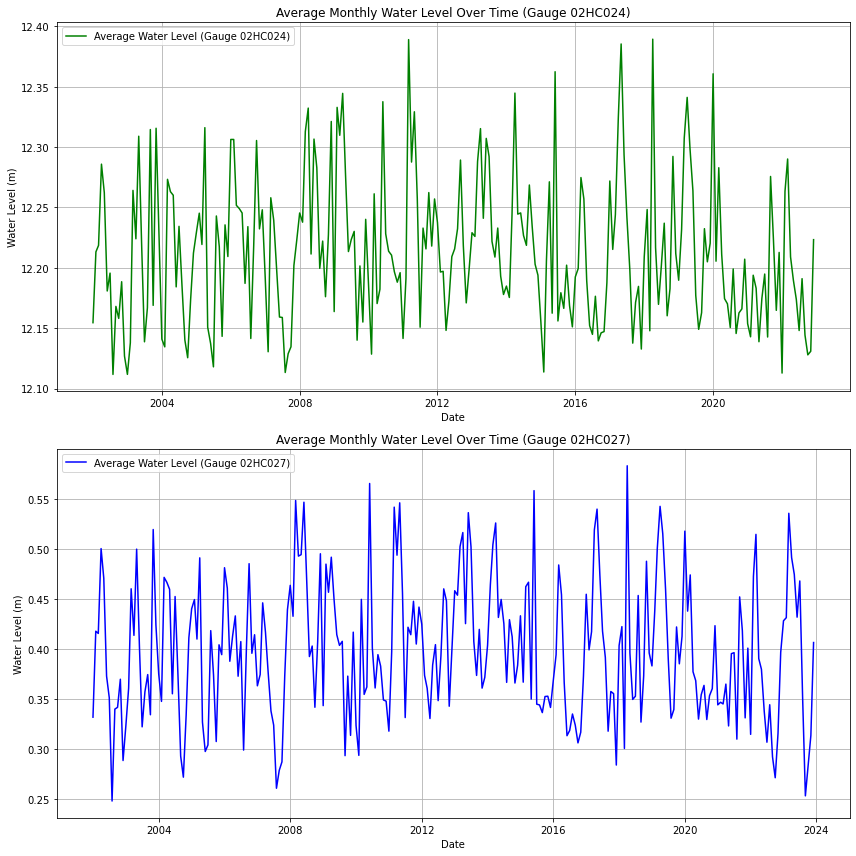

In [11]:
# Create a new column for Year-Month
flow_data_merged["YearMonth"] = flow_data_merged["Date"].dt.to_period("M").dt.to_timestamp()

# Filter data for each gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Group by Year-Month and calculate average water level for each gauge
monthly_water_level_gauge_1 = gauge_1_data.groupby("YearMonth")["water_level"].mean().reset_index()
monthly_water_level_gauge_2 = gauge_2_data.groupby("YearMonth")["water_level"].mean().reset_index()

# Plot the average monthly water level for each gauge
plt.figure(figsize=(12, 12))

# Subplot 1: Gauge 02HC024
plt.subplot(2, 1, 1)
plt.plot(
    monthly_water_level_gauge_1["YearMonth"],
    monthly_water_level_gauge_1["water_level"],
    color="green",
    label="Average Water Level (Gauge 02HC024)",
)
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Average Monthly Water Level Over Time (Gauge 02HC024)")
plt.grid(True)
plt.legend()

# Subplot 2: Gauge 02HC027
plt.subplot(2, 1, 2)
plt.plot(
    monthly_water_level_gauge_2["YearMonth"],
    monthly_water_level_gauge_2["water_level"],
    color="blue",
    label="Average Water Level (Gauge 02HC027)",
)
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Average Monthly Water Level Over Time (Gauge 02HC027)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


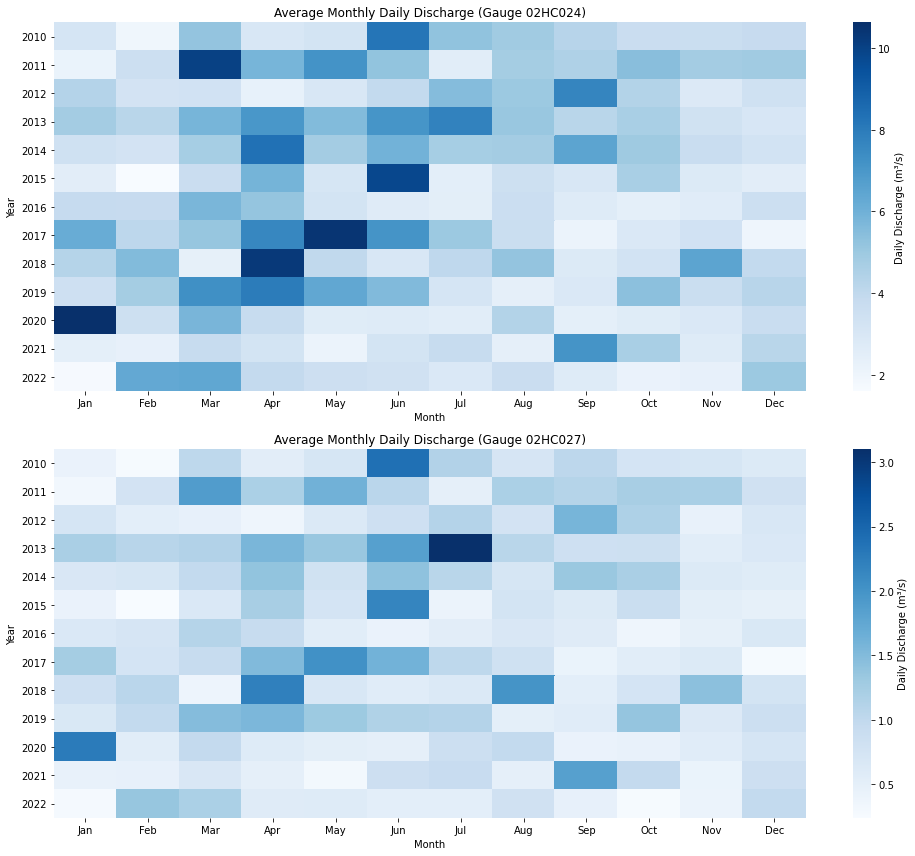

In [12]:
# Ensure 'Year' and 'Month' columns are extracted
flow_data_merged["Year"] = flow_data_merged["Date"].dt.year
flow_data_merged["Month"] = flow_data_merged["Date"].dt.month

# Filter data to 2010–2022
filtered_data = flow_data_merged[
    (flow_data_merged["Year"] >= 2010) & (flow_data_merged["Year"] <= 2022)
]

# Create pivot tables for each gauge
heatmap_data_gauge_1 = (
    filtered_data[filtered_data["ID"] == "02HC024"]
    .pivot_table(index="Year", columns="Month", values="daily_discharge", aggfunc="mean")
)
heatmap_data_gauge_2 = (
    filtered_data[filtered_data["ID"] == "02HC027"]
    .pivot_table(index="Year", columns="Month", values="daily_discharge", aggfunc="mean")
)

# Set up the figure
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot heatmap for Gauge 02HC024
sns.heatmap(
    heatmap_data_gauge_1,
    cmap="Blues",
    annot=False,
    ax=axes[0],
    cbar_kws={"label": "Daily Discharge (m³/s)"},
)
axes[0].set_title("Average Monthly Daily Discharge (Gauge 02HC024)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Year")
axes[0].set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)

# Plot heatmap for Gauge 02HC027
sns.heatmap(
    heatmap_data_gauge_2,
    cmap="Blues",
    annot=False,
    ax=axes[1],
    cbar_kws={"label": "Daily Discharge (m³/s)"},
)
axes[1].set_title("Average Monthly Daily Discharge (Gauge 02HC027)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Year")
axes[1].set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## Let's try to incorporate snowmelt data and analyze the correlation 

In [13]:
snowmelt_data = pd.read_csv('significant_snow_melt_events_after_freeze.csv')
snowmelt_data.head()

start_date    end_date  duration  mean_temperature
0  2002-06-04  2002-11-15       165         18.391515
1  2002-11-18  2002-11-26         9          3.566667
2  2002-12-10  2002-12-15         6          2.100000
3  2002-12-18  2002-12-22         5          3.040000
4  2003-03-15  2003-03-29        15          6.420000

In [14]:
# Ensure the date columns in both datasets are in datetime format
snowmelt_data["start_date"] = pd.to_datetime(snowmelt_data["start_date"])
snowmelt_data["end_date"] = pd.to_datetime(snowmelt_data["end_date"])
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])

# Add a column indicating whether a date falls within a snowmelt event
flow_data_merged["snowmelt_event"] = flow_data_merged["Date"].apply(
    lambda x: any((x >= start and x <= end) for start, end in zip(snowmelt_data["start_date"], snowmelt_data["end_date"]))
)


In [15]:
flow_data_merged.head()

ID       Date  daily_discharge  water_level  YearMonth  Year  Month  \
0  02HC024 2002-01-01            1.560       12.114 2002-01-01  2002      1   
1  02HC027 2002-01-01            0.193        0.263 2002-01-01  2002      1   
2  02HC024 2002-01-02            1.490       12.108 2002-01-01  2002      1   
3  02HC027 2002-01-02            0.186        0.305 2002-01-01  2002      1   
4  02HC027 2002-01-03            0.185        0.252 2002-01-01  2002      1   

   snowmelt_event  
0           False  
1           False  
2           False  
3           False  
4           False

In [16]:
# Filter data for snowmelt and non-snowmelt periods
snowmelt_period_data = flow_data_merged[flow_data_merged["snowmelt_event"] == True]
non_snowmelt_period_data = flow_data_merged[flow_data_merged["snowmelt_event"] == False]

# Compute summary statistics
print("Snowmelt Period Statistics:")
print(snowmelt_period_data[["daily_discharge", "water_level"]].describe())

print("\nNon-Snowmelt Period Statistics:")
print(non_snowmelt_period_data[["daily_discharge", "water_level"]].describe())


Snowmelt Period Statistics:
       daily_discharge   water_level
count     11684.000000  11616.000000
mean          2.709326      6.134863
std           4.244715      5.908261
min           0.064000      0.199000
25%           0.406000      0.339000
50%           1.550000      0.853500
75%           3.040000     12.171000
max          80.300000     13.541000

Non-Snowmelt Period Statistics:
       daily_discharge  water_level
count      4021.000000  4007.000000
mean          2.147509     6.184917
std           3.471583     5.905409
min           0.086000     0.209000
25%           0.370000     0.346000
50%           1.480000     0.873000
75%           2.520000    12.157000
max          66.700000    13.385000


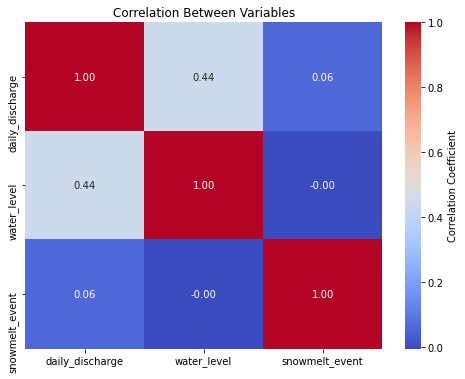

In [17]:
# Select relevant columns for correlation
correlation_data = flow_data_merged[["daily_discharge", "water_level", "snowmelt_event"]].dropna()

# Compute correlation
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"label": "Correlation Coefficient"})
plt.title("Correlation Between Variables")
plt.show()


### Let's look at the yearly average discharge and analyze the data

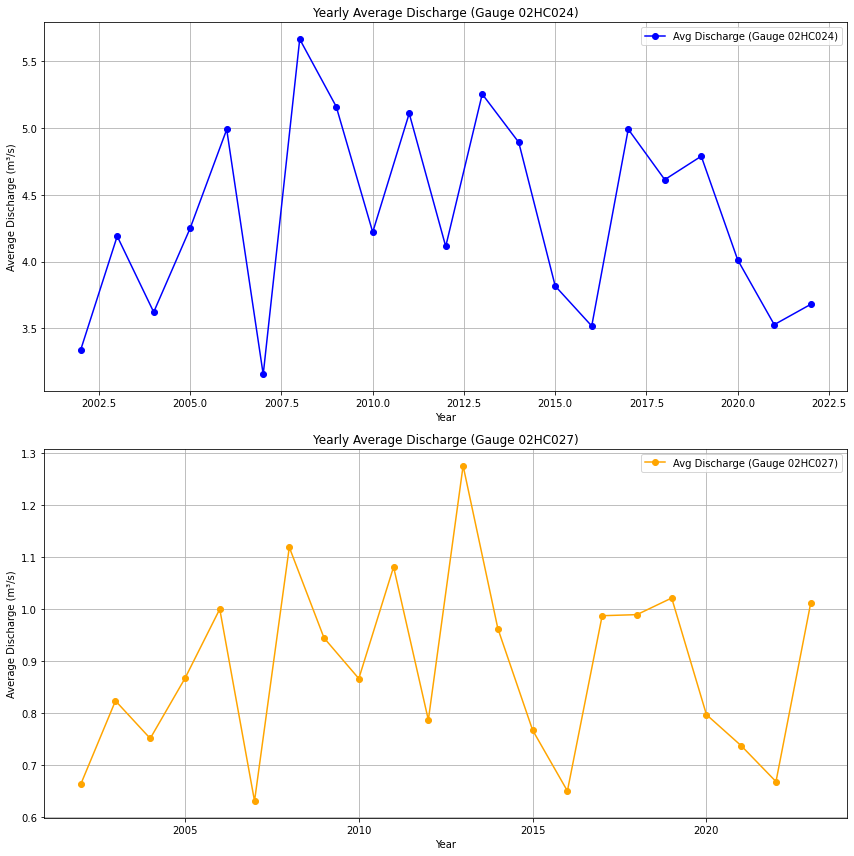

In [18]:
# Aggregate data by year for each gauge
gauge_1_yearly_discharge = (
    flow_data_merged[flow_data_merged["ID"] == "02HC024"]
    .groupby(flow_data_merged["Date"].dt.year)["daily_discharge"]
    .mean()
    .reset_index()
)
gauge_1_yearly_discharge.columns = ["Year", "Avg Discharge"]

gauge_2_yearly_discharge = (
    flow_data_merged[flow_data_merged["ID"] == "02HC027"]
    .groupby(flow_data_merged["Date"].dt.year)["daily_discharge"]
    .mean()
    .reset_index()
)
gauge_2_yearly_discharge.columns = ["Year", "Avg Discharge"]

# Create the plot
plt.figure(figsize=(12, 12))

# Subplot 1: Gauge 02HC024
plt.subplot(2, 1, 1)
plt.plot(
    gauge_1_yearly_discharge["Year"],
    gauge_1_yearly_discharge["Avg Discharge"],
    color="blue",
    marker="o",
    label="Avg Discharge (Gauge 02HC024)",
)
plt.xlabel("Year")
plt.ylabel("Average Discharge (m³/s)")
plt.title("Yearly Average Discharge (Gauge 02HC024)")
plt.grid(True)
plt.legend()

# Subplot 2: Gauge 02HC027
plt.subplot(2, 1, 2)
plt.plot(
    gauge_2_yearly_discharge["Year"],
    gauge_2_yearly_discharge["Avg Discharge"],
    color="orange",
    marker="o",
    label="Avg Discharge (Gauge 02HC027)",
)
plt.xlabel("Year")
plt.ylabel("Average Discharge (m³/s)")
plt.title("Yearly Average Discharge (Gauge 02HC027)")
plt.grid(True)
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


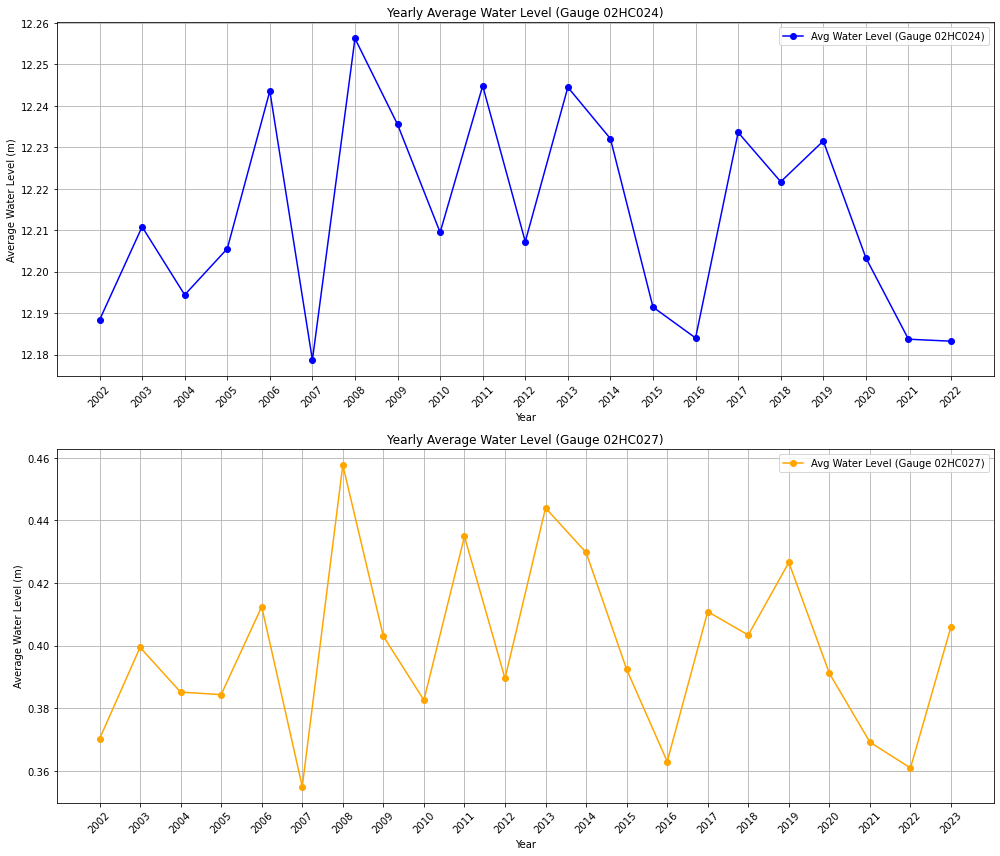

In [ ]:
# Aggregate data by year for each gauge
gauge_1_yearly_avg_water_level = (
    flow_data_merged[flow_data_merged["ID"] == "02HC024"]
    .groupby(flow_data_merged["Date"].dt.year)["water_level"]
    .mean()
)

gauge_2_yearly_avg_water_level = (
    flow_data_merged[flow_data_merged["ID"] == "02HC027"]
    .groupby(flow_data_merged["Date"].dt.year)["water_level"]
    .mean()
)

# Create the plot
plt.figure(figsize=(14, 12))

# Subplot 1: Gauge 02HC024
plt.subplot(2, 1, 1)
plt.plot(
    gauge_1_yearly_avg_water_level.index,
    gauge_1_yearly_avg_water_level.values,
    marker="o",
    label="Avg Water Level (Gauge 02HC024)",
    color="blue",
)
plt.xticks(
    np.arange(
        gauge_1_yearly_avg_water_level.index.min(),
        gauge_1_yearly_avg_water_level.index.max() + 1,
        step=1,
    ),
    rotation=45,
)
plt.xlabel("Year")
plt.ylabel("Average Water Level (m)")
plt.title("Yearly Average Water Level (Gauge 02HC024)")
plt.legend()
plt.grid(True)

# Subplot 2: Gauge 02HC027
plt.subplot(2, 1, 2)
plt.plot(
    gauge_2_yearly_avg_water_level.index,
    gauge_2_yearly_avg_water_level.values,
    marker="o",
    label="Avg Water Level (Gauge 02HC027)",
    color="orange",
)
plt.xticks(
    np.arange(
        gauge_2_yearly_avg_water_level.index.min(),
        gauge_2_yearly_avg_water_level.index.max() + 1,
        step=1,
    ),
    rotation=45,
)
plt.xlabel("Year")
plt.ylabel("Average Water Level (m)")
plt.title("Yearly Average Water Level (Gauge 02HC027)")
plt.legend()
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


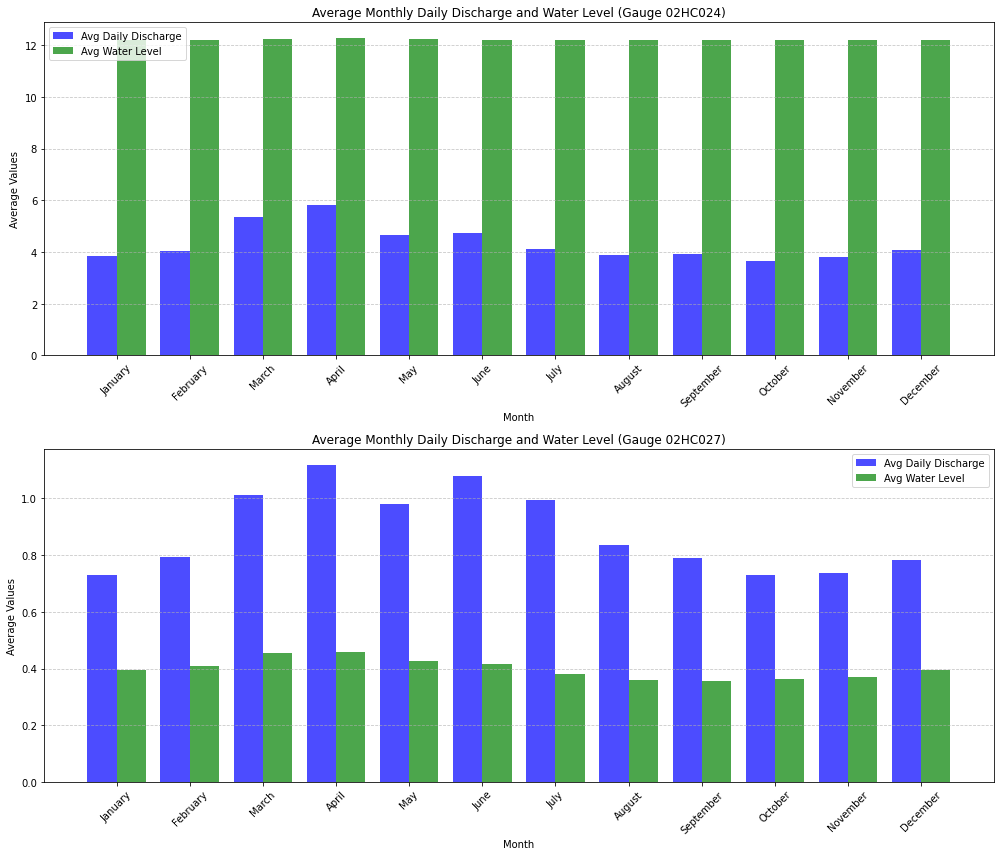

In [20]:
# Filter data by gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Group data by Month and calculate averages for each gauge
gauge_1_monthly_avg = (
    gauge_1_data.groupby(gauge_1_data["Date"].dt.month)[
        ["daily_discharge", "water_level"]
    ].mean()
)
gauge_2_monthly_avg = (
    gauge_2_data.groupby(gauge_2_data["Date"].dt.month)[
        ["daily_discharge", "water_level"]
    ].mean()
)

# Rename the index to month names
gauge_1_monthly_avg.index = [calendar.month_name[i] for i in gauge_1_monthly_avg.index]
gauge_2_monthly_avg.index = [calendar.month_name[i] for i in gauge_2_monthly_avg.index]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot for Gauge 02HC024
x = range(len(gauge_1_monthly_avg))
width = 0.4
axes[0].bar(
    x,
    gauge_1_monthly_avg["daily_discharge"],
    width=width,
    label="Avg Daily Discharge",
    color="blue",
    alpha=0.7,
)
axes[0].bar(
    [i + width for i in x],
    gauge_1_monthly_avg["water_level"],
    width=width,
    label="Avg Water Level",
    color="green",
    alpha=0.7,
)
axes[0].set_xticks([i + width / 2 for i in x])
axes[0].set_xticklabels(gauge_1_monthly_avg.index, rotation=45)
axes[0].set_title("Average Monthly Daily Discharge and Water Level (Gauge 02HC024)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Average Values")
axes[0].legend()
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot for Gauge 02HC027
x = range(len(gauge_2_monthly_avg))
axes[1].bar(
    x,
    gauge_2_monthly_avg["daily_discharge"],
    width=width,
    label="Avg Daily Discharge",
    color="blue",
    alpha=0.7,
)
axes[1].bar(
    [i + width for i in x],
    gauge_2_monthly_avg["water_level"],
    width=width,
    label="Avg Water Level",
    color="green",
    alpha=0.7,
)
axes[1].set_xticks([i + width / 2 for i in x])
axes[1].set_xticklabels(gauge_2_monthly_avg.index, rotation=45)
axes[1].set_title("Average Monthly Daily Discharge and Water Level (Gauge 02HC027)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Average Values")
axes[1].legend()
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### We can notice that daily discharge starts to increase during snowmelt period. However for better visualization let's focus on last 10 years

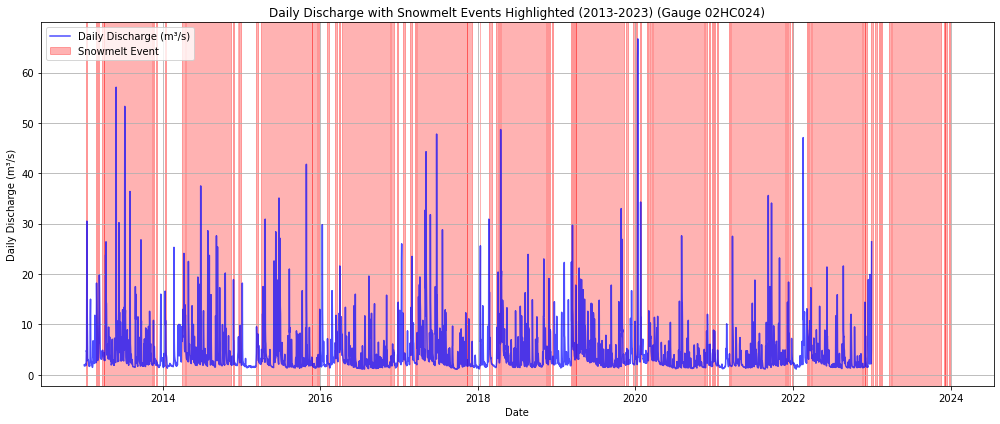

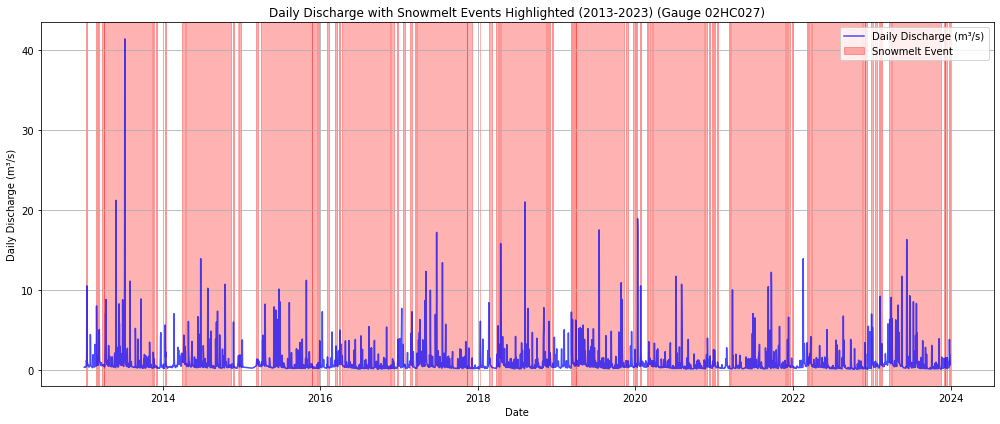

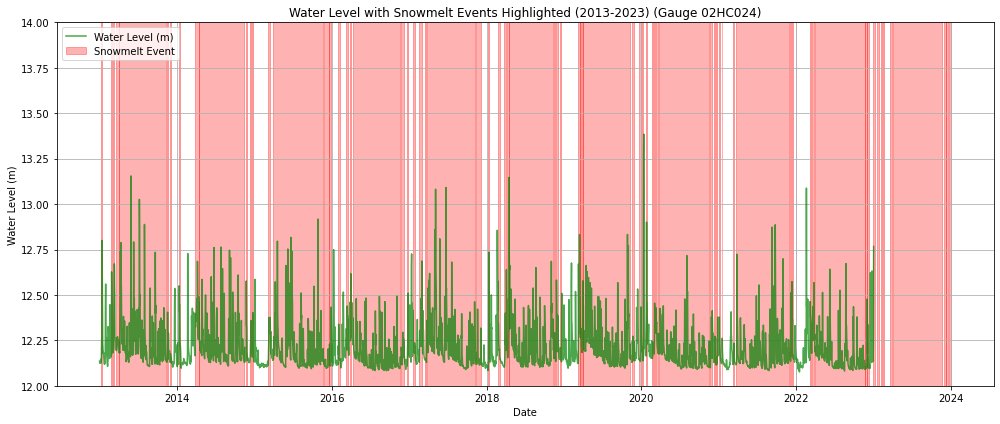

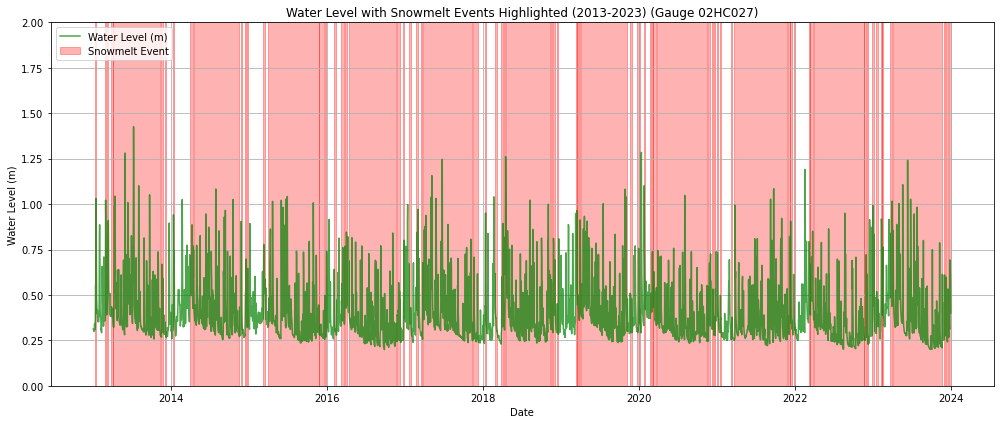

In [21]:
# Define the desired date range 
start_date = pd.Timestamp("2013-01-01")
end_date = pd.Timestamp("2023-12-31")

# Filter data by gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Helper function to plot
def plot_with_snowmelt(data, parameter, ylabel, title, color, ylim=None, gauge=None):
    plt.figure(figsize=(14, 6))
    plt.plot(
        data[(data["Date"] >= start_date) & (data["Date"] <= end_date)]["Date"],
        data[(data["Date"] >= start_date) & (data["Date"] <= end_date)][parameter],
        label=ylabel,
        color=color,
        alpha=0.7,
    )

    # Highlight snowmelt periods
    added_legend = False
    for _, row in snowmelt_data[(snowmelt_data["start_date"] >= start_date) & (snowmelt_data["end_date"] <= end_date)].iterrows():
        plt.axvspan(
            row["start_date"],
            row["end_date"],
            color="red",
            alpha=0.3,
            label="Snowmelt Event" if not added_legend else None,  # Add legend only once
        )
        added_legend = True

    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(f"{title} (Gauge {gauge})" if gauge else title)
    if ylim:
        plt.ylim(*ylim)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot Daily Discharge for each gauge
plot_with_snowmelt(
    gauge_1_data, 
    "daily_discharge", 
    "Daily Discharge (m³/s)", 
    "Daily Discharge with Snowmelt Events Highlighted (2013-2023)", 
    "blue", 
    gauge="02HC024"
)

plot_with_snowmelt(
    gauge_2_data, 
    "daily_discharge", 
    "Daily Discharge (m³/s)", 
    "Daily Discharge with Snowmelt Events Highlighted (2013-2023)", 
    "blue", 
    gauge="02HC027"
)

# Plot Water Level for each gauge
plot_with_snowmelt(
    gauge_1_data, 
    "water_level", 
    "Water Level (m)", 
    "Water Level with Snowmelt Events Highlighted (2013-2023)", 
    "green", 
    ylim=(12, 14), 
    gauge="02HC024"
)

plot_with_snowmelt(
    gauge_2_data, 
    "water_level", 
    "Water Level (m)", 
    "Water Level with Snowmelt Events Highlighted (2013-2023)", 
    "green", 
    ylim=(0, 2), 
    gauge="02HC027"
)


### We will merge these two graphs for better comparison below

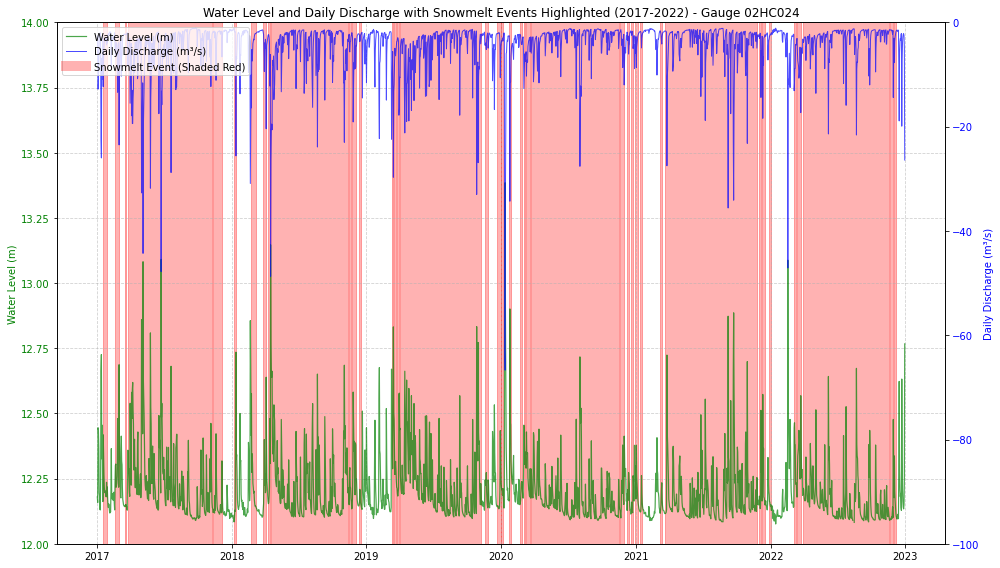

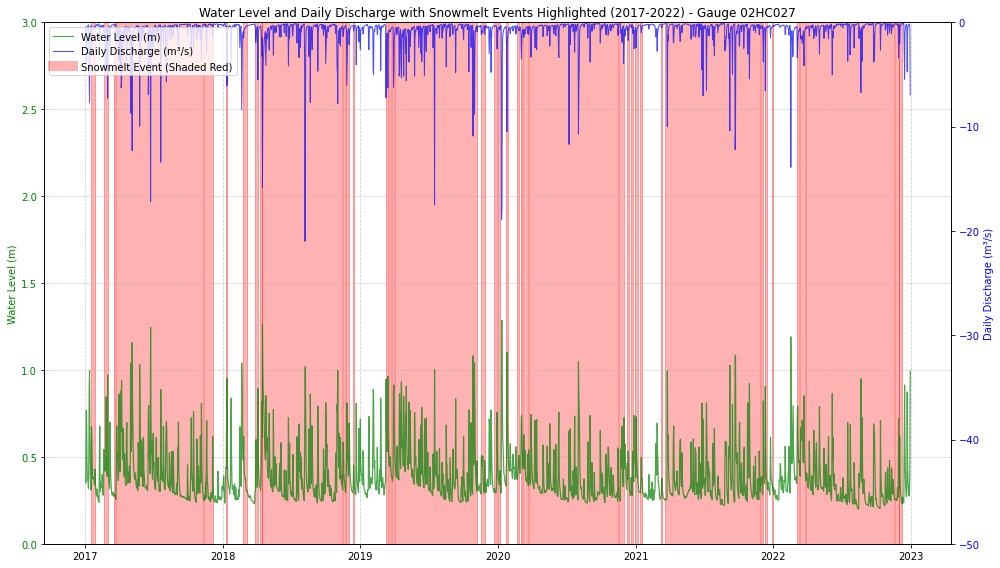

In [22]:
# Define the date range 
start_date = pd.Timestamp("2017-01-01")
end_date = pd.Timestamp("2022-12-31")

# Filter data for each gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Helper function to plot 
def plot_gauge_data_with_snowmelt(data, gauge_id, water_level_ylim=(12, 14), discharge_ylim=(-70, 0)):
    # Filter data for the given date range
    filtered_data = data[
        (data["Date"] >= start_date) & (data["Date"] <= end_date)
    ]

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot Water Level (Above the X-Axis)
    water_level_line = ax1.plot(
        filtered_data["Date"],
        filtered_data["water_level"],
        label="Water Level (m)",
        color="green",
        alpha=0.7,
        linewidth=1.2,
    )

    # Set Water Level axis properties
    ax1.set_ylabel("Water Level (m)", color="green")
    ax1.set_ylim(water_level_ylim)  # Set Water Level range dynamically
    ax1.tick_params(axis="y", labelcolor="green")

    # Add a secondary axis for Daily Discharge (Below the X-Axis)
    ax2 = ax1.twinx()
    daily_discharge_line = ax2.plot(
        filtered_data["Date"],
        -filtered_data["daily_discharge"],  # Flip discharge values to go below X-axis
        label="Daily Discharge (m³/s)",
        color="blue",
        alpha=0.7,
        linewidth=1,
    )

    # Set Daily Discharge axis properties
    ax2.set_ylabel("Daily Discharge (m³/s)", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(discharge_ylim)  

    # Highlight Snowmelt Events
    for _, row in snowmelt_data[
        (snowmelt_data["start_date"] >= start_date) & (snowmelt_data["end_date"] <= end_date)
    ].iterrows():
        ax1.axvspan(
            row["start_date"],
            row["end_date"],
            color="red",
            alpha=0.3,
        )

    # Add a legend entry for Snowmelt Event
    snowmelt_patch = plt.Line2D(
        [0], [0],
        color="red",
        alpha=0.3,
        linewidth=10,
        label="Snowmelt Event (Shaded Red)"
    )

    # Format X-axis
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)

    # Add grid, title, and legend
    plt.title(f"Water Level and Daily Discharge with Snowmelt Events Highlighted (2017-2022) - Gauge {gauge_id}")
    ax1.grid(True, linestyle="--", alpha=0.6)

    # Combine Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2 + [snowmelt_patch], labels1 + labels2 + ["Snowmelt Event (Shaded Red)"], loc="upper left")

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Plot for Gauge 02HC024 
plot_gauge_data_with_snowmelt(gauge_1_data, "02HC024", water_level_ylim=(12, 14), discharge_ylim=(-100, 0))

# Plot for Gauge 02HC027 
plot_gauge_data_with_snowmelt(gauge_2_data, "02HC027", water_level_ylim=(0, 3), discharge_ylim=(-50, 0))


## Now let's analyze how significant rain events impact water level and daily discharge 

In [23]:
significant_rain_events = pd.read_csv('significant_rain_events_filtered.csv')

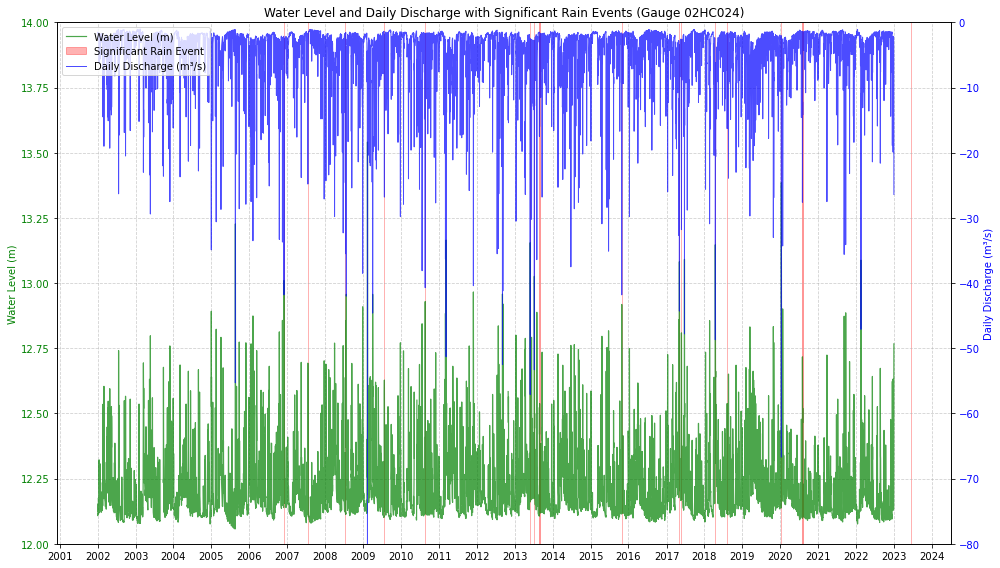

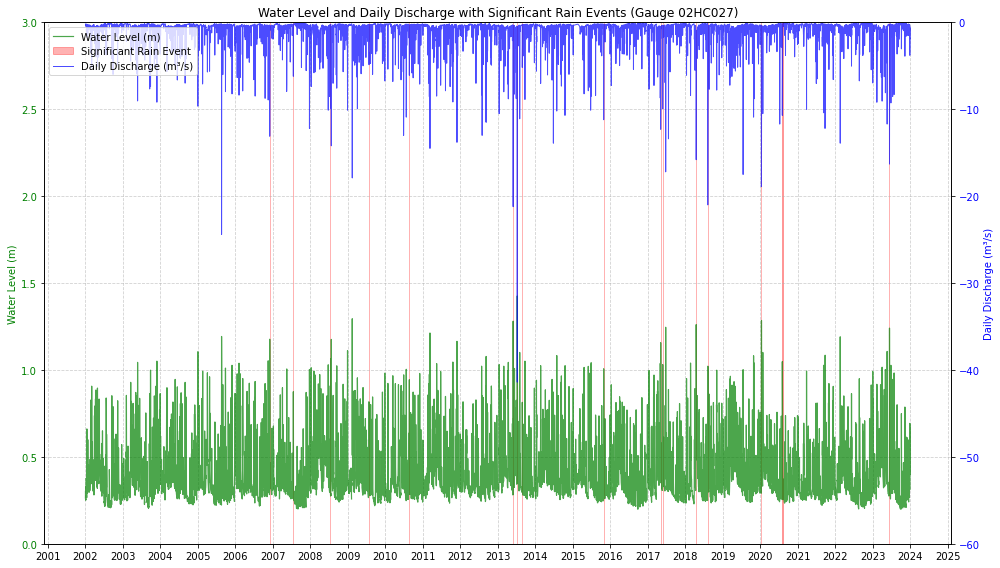

In [24]:
# Helper function for plotting 
def plot_gauge_with_rain_events(data, rain_events, gauge_id, start_date, end_date, water_level_ylim=(12, 14), discharge_ylim=(-70, 0)):
    # Filter data for the given date range
    filtered_data = data[(data["Date"] >= start_date) & (data["Date"] <= end_date)]

    # Filter significant rain events for the date range
    rain_events["start_date"] = pd.to_datetime(rain_events["start_date"])
    rain_events["end_date"] = pd.to_datetime(rain_events["end_date"])
    filtered_rain_events = rain_events[
        (rain_events["start_date"] >= start_date) & 
        (rain_events["end_date"] <= end_date)
    ]

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot Water Level (Above the X-Axis)
    ax1.plot(
        filtered_data["Date"],
        filtered_data["water_level"],
        label="Water Level (m)",
        color="green",
        alpha=0.7,
        linewidth=1.2,
    )
    ax1.set_ylabel("Water Level (m)", color="green")
    ax1.set_ylim(water_level_ylim)  
    ax1.tick_params(axis="y", labelcolor="green")

    # Add a secondary axis for Daily Discharge (Below the X-Axis)
    ax2 = ax1.twinx()
    ax2.plot(
        filtered_data["Date"],
        -filtered_data["daily_discharge"],  # Flip discharge values to go below X-axis
        label="Daily Discharge (m³/s)",
        color="blue",
        alpha=0.7,
        linewidth=1,
    )
    ax2.set_ylabel("Daily Discharge (m³/s)", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(discharge_ylim)  

    # Highlight Significant Rain Events
    for _, row in filtered_rain_events.iterrows():
        ax1.axvspan(
            row["start_date"],
            row["end_date"],
            color="red",
            alpha=0.3,
            label="Significant Rain Event" if _ == 0 else None,
        )

    # Format X-axis
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)

    # Add grid, title, and legend
    plt.title(f"Water Level and Daily Discharge with Significant Rain Events (Gauge {gauge_id})")
    ax1.grid(True, linestyle="--", alpha=0.6)

    # Combine Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


# Define the date range
start_date = pd.Timestamp("2002-01-01")
end_date = pd.Timestamp("2023-12-31")

# Filter data by gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Plot for Gauge 02HC024
plot_gauge_with_rain_events(
    data=gauge_1_data,
    rain_events=significant_rain_events,
    gauge_id="02HC024",
    start_date=start_date,
    end_date=end_date,
    water_level_ylim=(12, 14),  
    discharge_ylim=(-80, 0)
)

# Plot for Gauge 02HC027
plot_gauge_with_rain_events(
    data=gauge_2_data,
    rain_events=significant_rain_events,
    gauge_id="02HC027",
    start_date=start_date,
    end_date=end_date,
    water_level_ylim=(0, 3),  
    discharge_ylim=(-60, 0)
)


### The duration of the rain events are short. Thus, let's narrow done tha date range so we can look at each event closer and analyze it. If the duration. Also, one day events are represented by a thin line, thus we will adjust the date to better visualize the graphs.

In [25]:
def plot_significant_rain_events(data, rain_events, gauge_id, water_level_ylim=(11, 14), discharge_ylim=(-70, 0)):
    """
    Generate plots for significant rain events for a specific gauge.

    Args:
        data (DataFrame): Filtered data for a specific gauge.
        rain_events (DataFrame): Significant rain events data.
        gauge_id (str): Gauge ID for labeling the plots.
        water_level_ylim (tuple): Y-axis limits for water level.
        discharge_ylim (tuple): Y-axis limits for daily discharge.
    """
    # Extend start and end dates by ±10 days
    rain_events["extended_start_date"] = rain_events["start_date"] - pd.Timedelta(days=10)
    rain_events["extended_end_date"] = rain_events["end_date"] + pd.Timedelta(days=10)

    for index, row in rain_events.iterrows():
        extended_start = row["extended_start_date"]
        extended_end = row["extended_end_date"]
        event_start = row["start_date"]
        event_end = row["end_date"]
        
        # Extend only the end date by 1 day for short events
        adjusted_end = event_end + pd.Timedelta(days=1) if (event_end - event_start).days < 2 else event_end
        
        # Filter flow data for the extended date range
        event_data = data[
            (data["Date"] >= extended_start) & (data["Date"] <= extended_end)
        ]
        
        # Create a new plot
        fig, ax1 = plt.subplots(figsize=(14, 8))
        
        # Plot Water Level
        ax1.plot(
            event_data["Date"],
            event_data["water_level"],
            label="Water Level (m)",
            color="green",
            alpha=0.7,
            linewidth=1.2,
        )
        ax1.set_ylabel("Water Level (m)", color="green")
        ax1.tick_params(axis="y", labelcolor="green")
        ax1.set_ylim(water_level_ylim)  
        
        # Add a secondary axis for Daily Discharge
        ax2 = ax1.twinx()
        ax2.plot(
            event_data["Date"],
            -event_data["daily_discharge"],  # Flip discharge values to go below X-axis
            label="Daily Discharge (Below Axis, m³/s)",
            color="blue",
            alpha=0.7,
            linewidth=1,
        )
        ax2.set_ylabel("Daily Discharge (m³/s, Below Axis)", color="blue")
        ax2.tick_params(axis="y", labelcolor="blue")
        ax2.set_ylim(discharge_ylim)  
        
        # Highlight the original rain event period with adjusted bounds
        ax1.axvspan(event_start, adjusted_end, color="red", alpha=0.3, label="Rain Event Period")
        
        # Add title and legend
        plt.title(
            f"Water Level and Daily Discharge for Significant Rain Event\n"
            f"Gauge: {gauge_id}\n"
            f"Start Date: {row['start_date'].date()}, End Date: {row['end_date'].date()}\n"
            f"Total Precipitation: {row['total_precipitation']} mm, Avg Intensity: {row['average_intensity']} mm/day"
        )
        ax1.grid(True, linestyle="--", alpha=0.6)
        
        # Combine Legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
        
        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()


# Filter data for each gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Filter significant rain events 
significant_rain_events["start_date"] = pd.to_datetime(significant_rain_events["start_date"])
significant_rain_events["end_date"] = pd.to_datetime(significant_rain_events["end_date"])


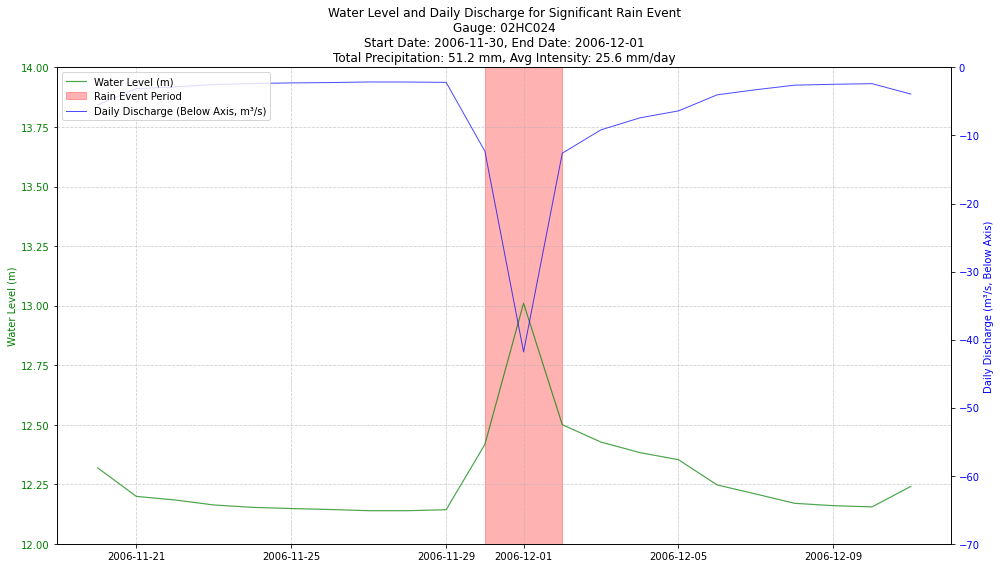

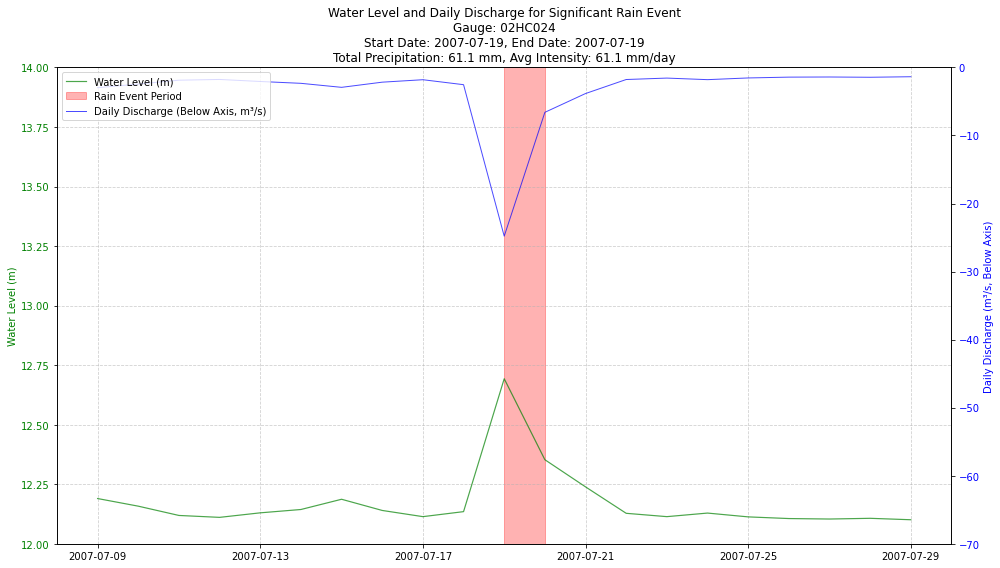

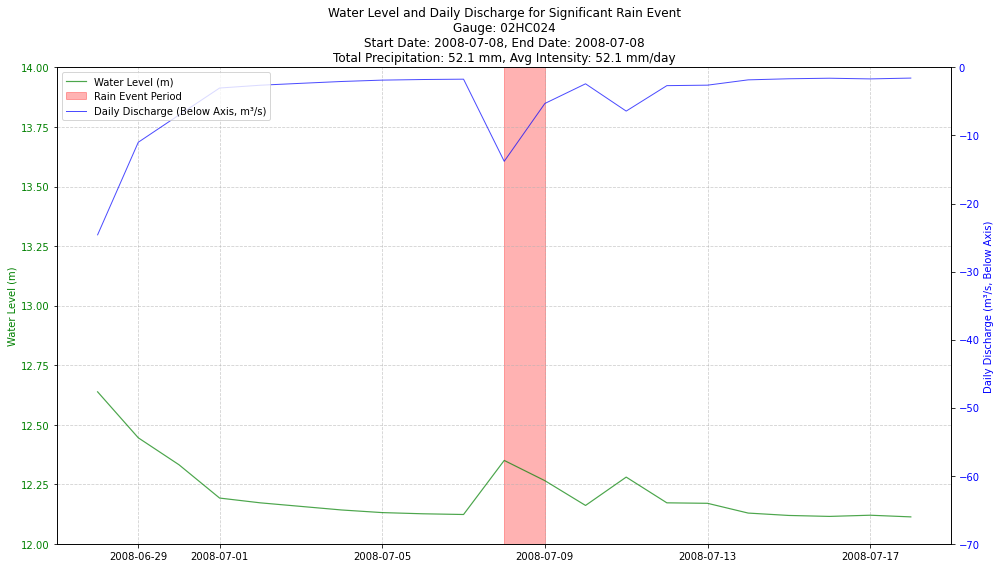

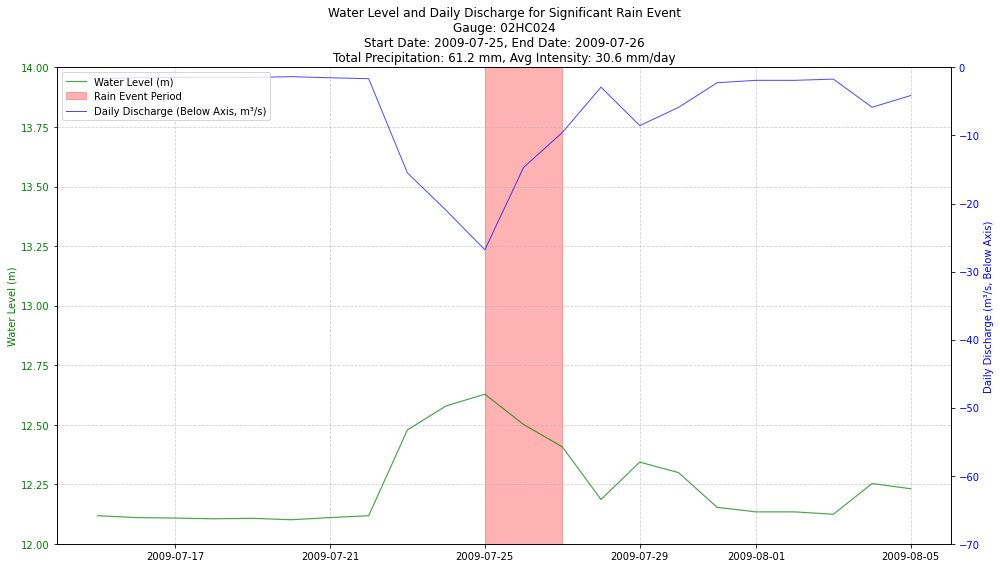

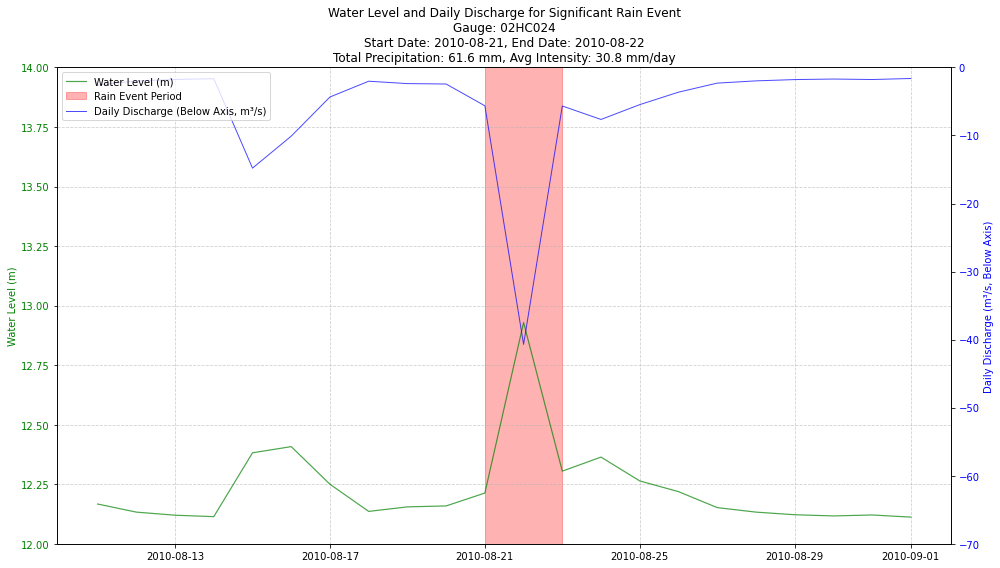

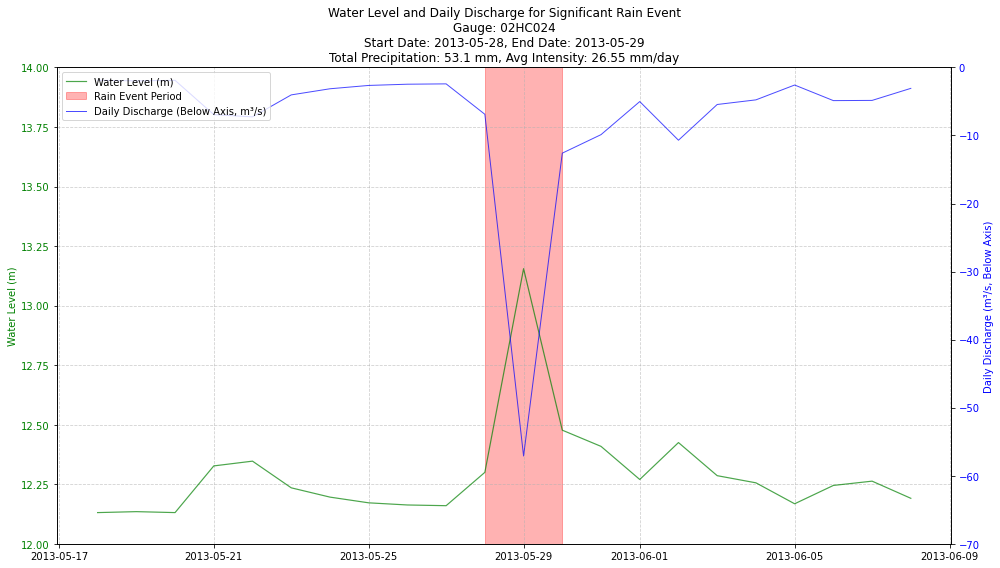

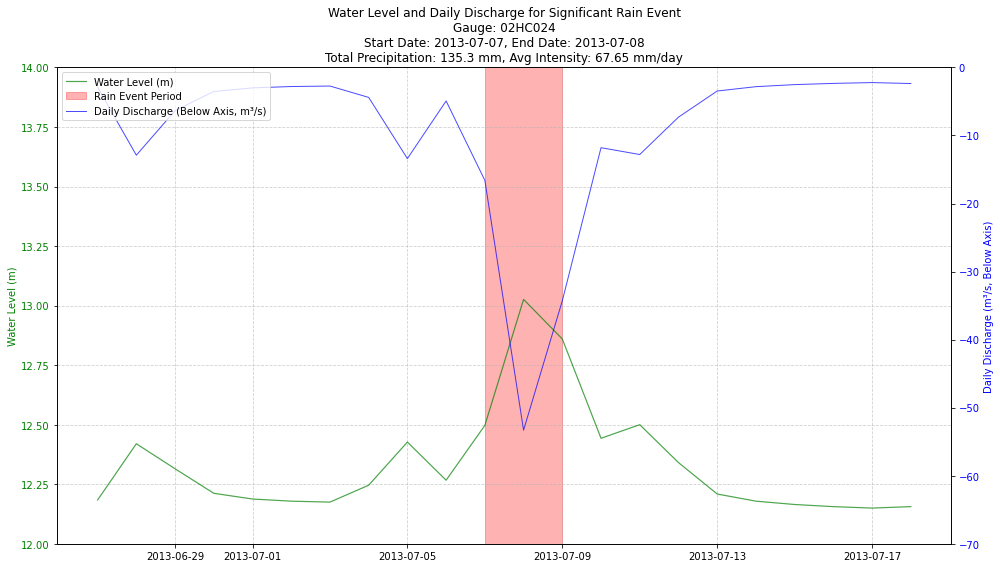

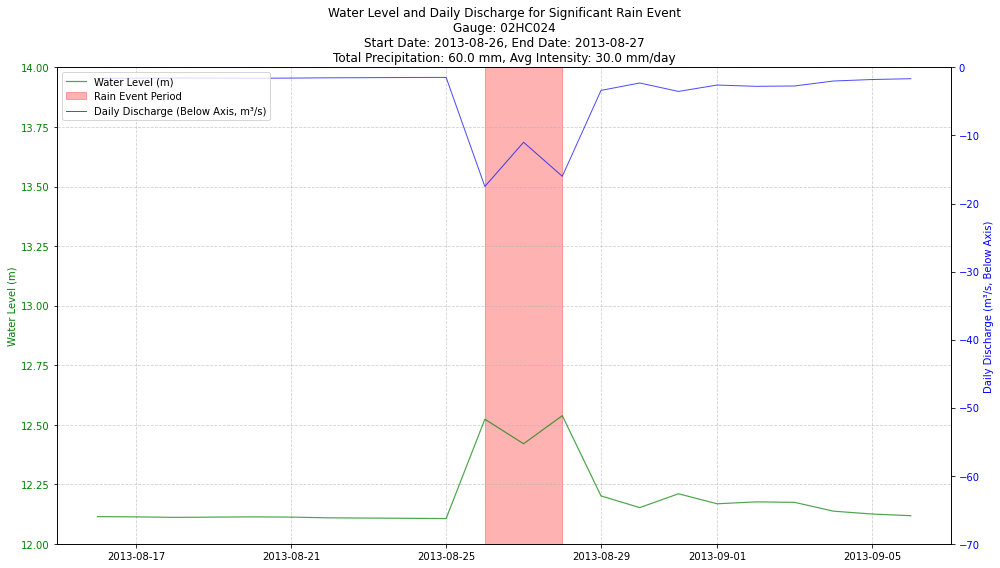

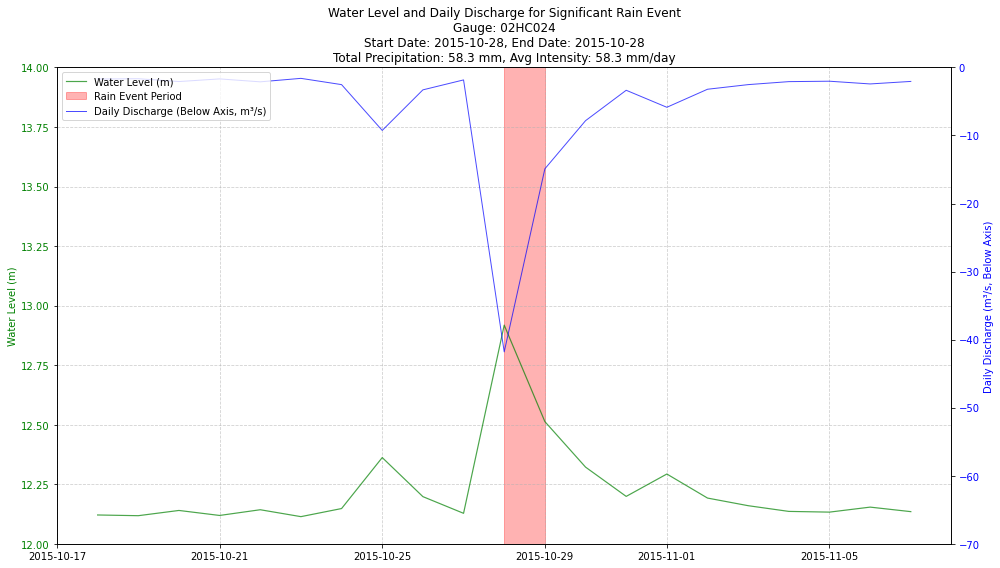

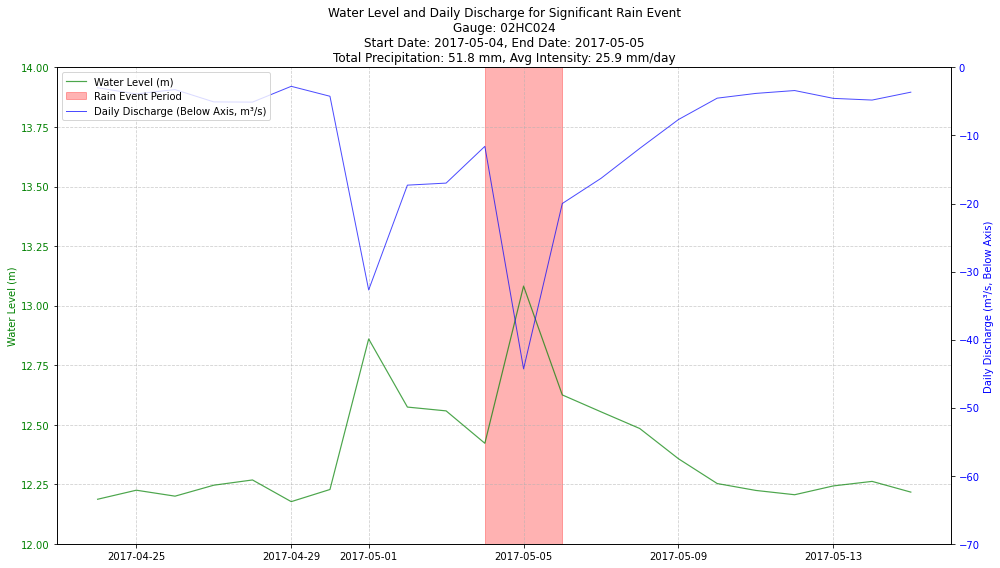

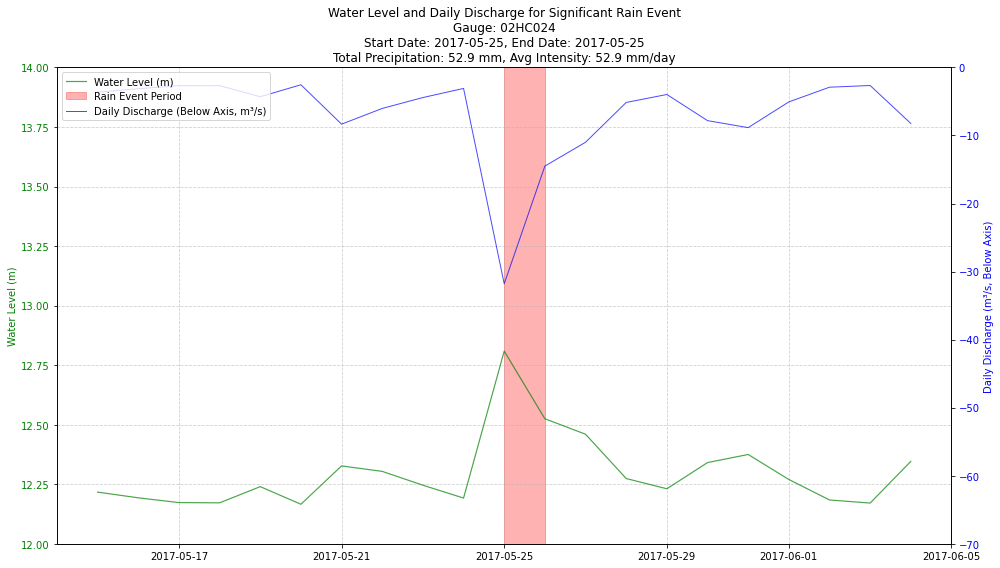

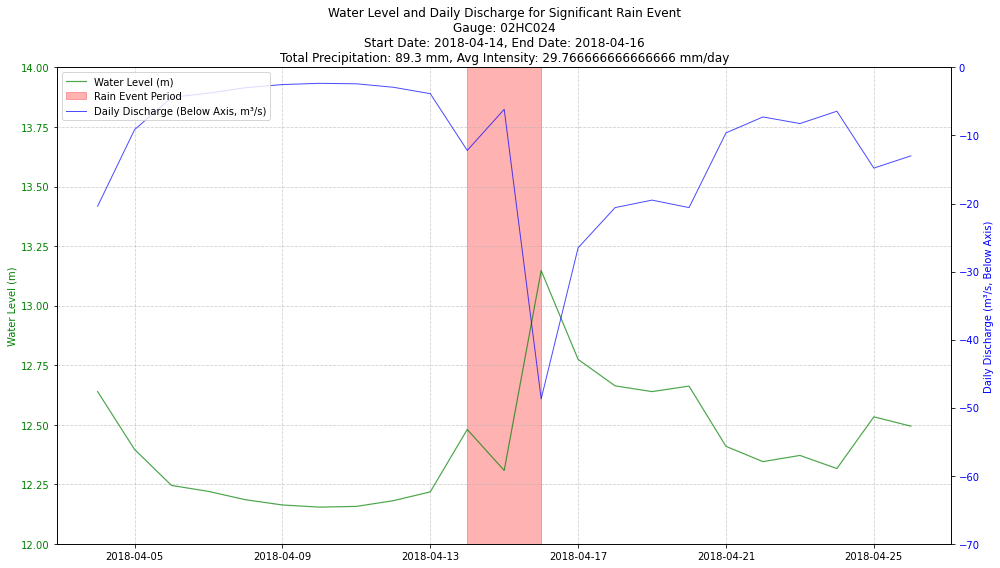

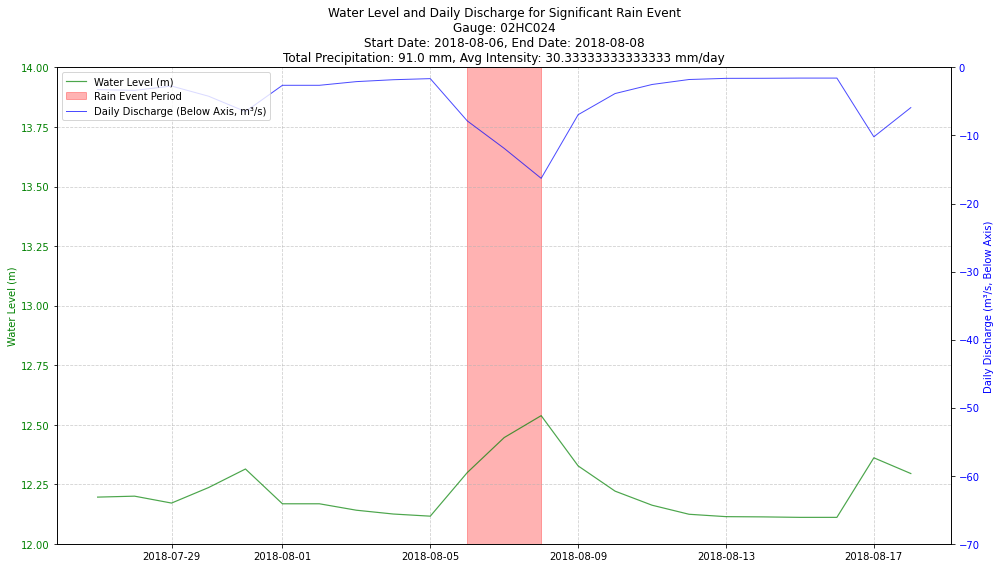

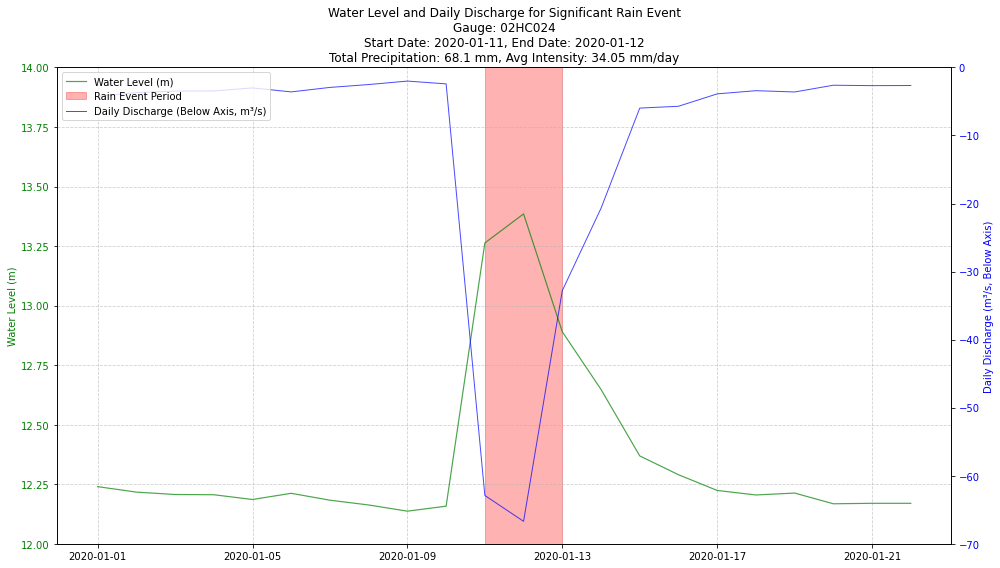

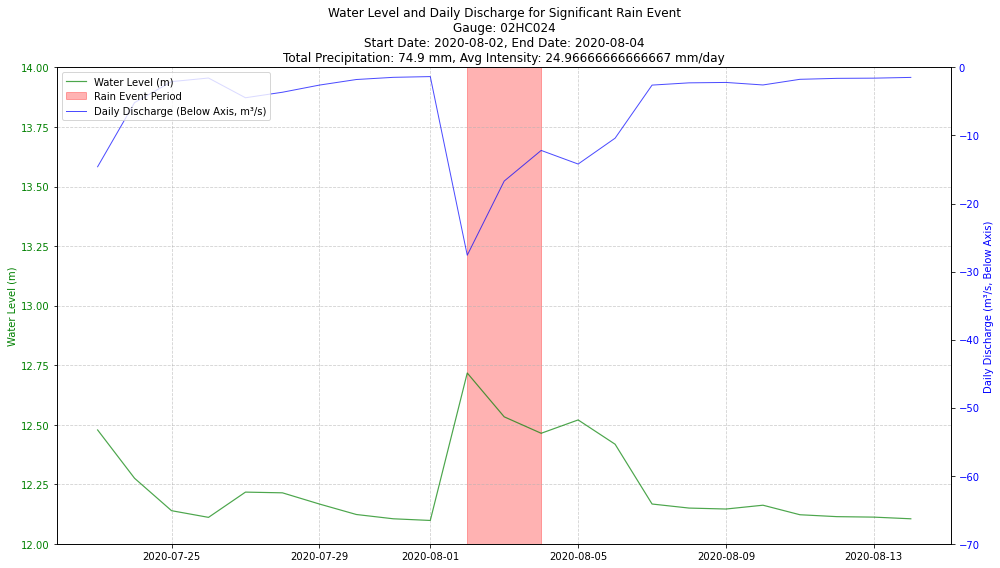

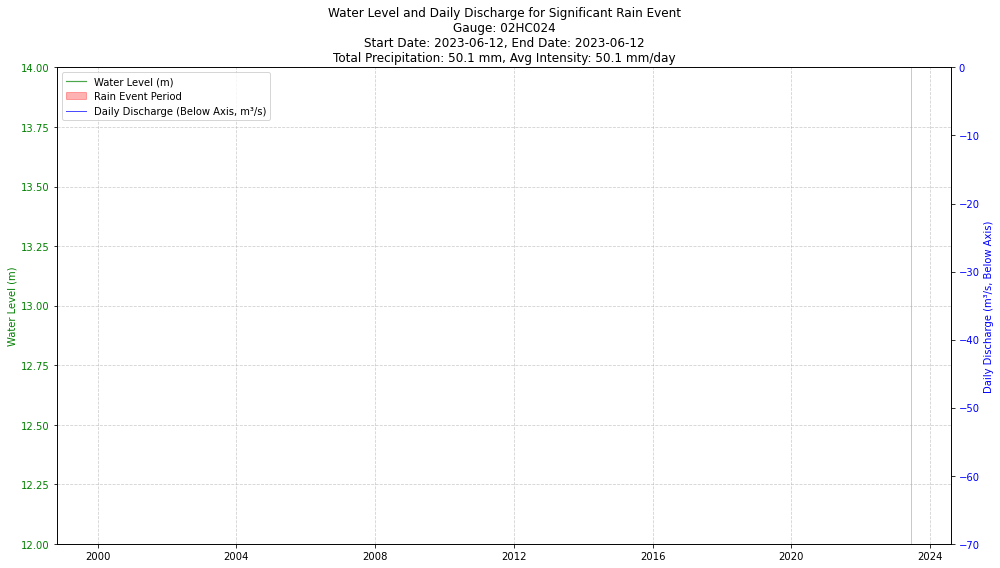

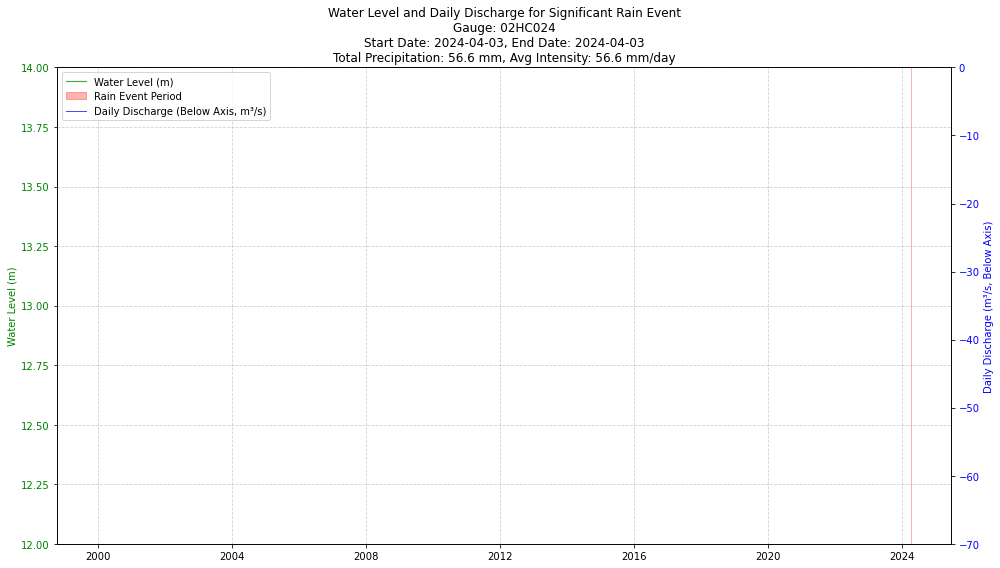

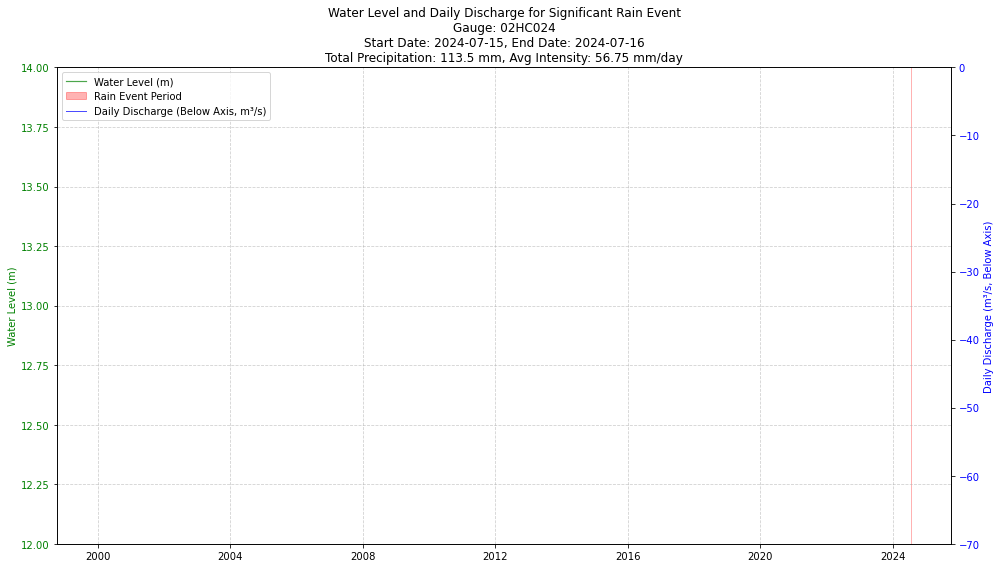

In [26]:
# Plot for Gauge 02HC024
plot_significant_rain_events(
    data=gauge_1_data,
    rain_events=significant_rain_events,
    gauge_id="02HC024",
    water_level_ylim=(12, 14),
    discharge_ylim=(-70, 0)
)

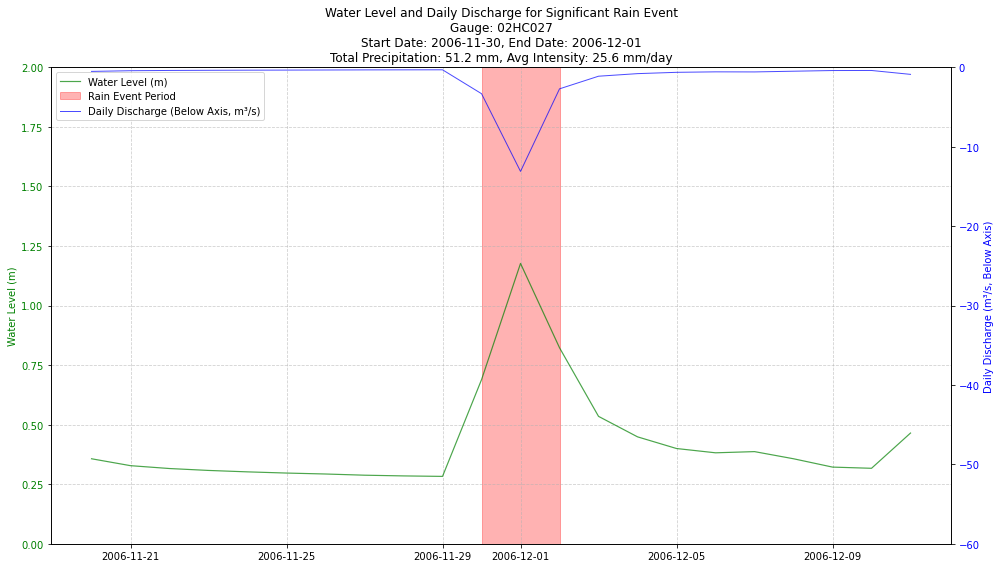

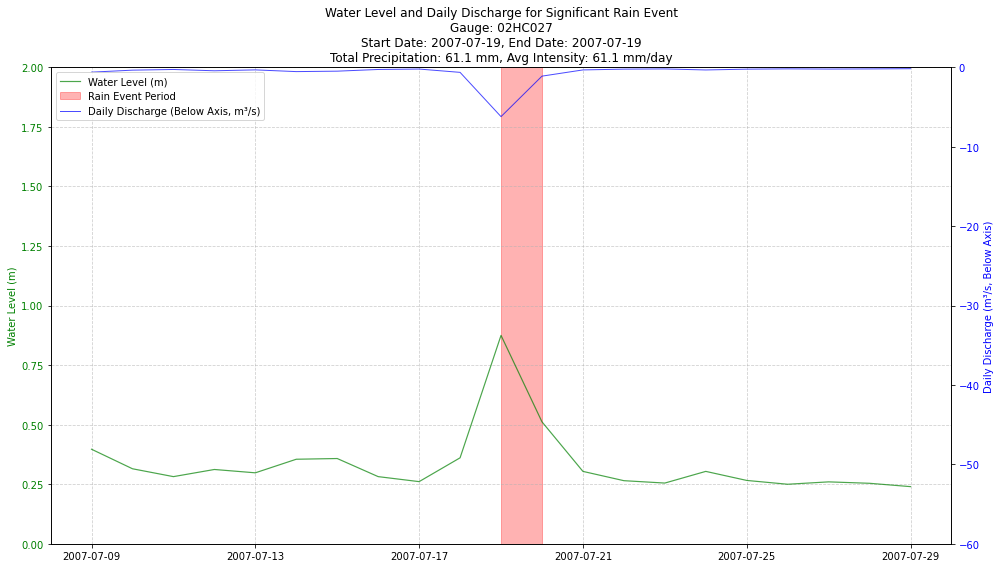

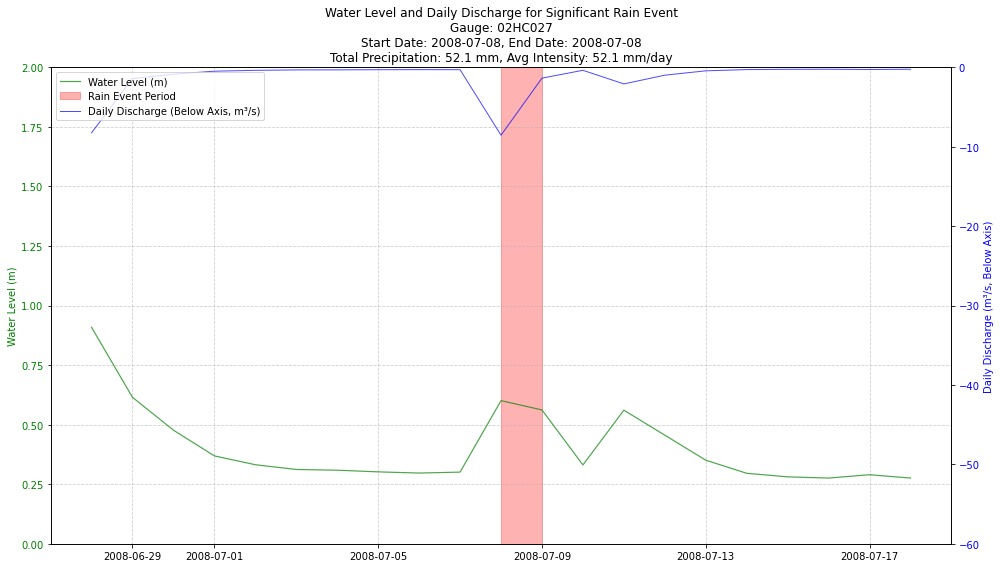

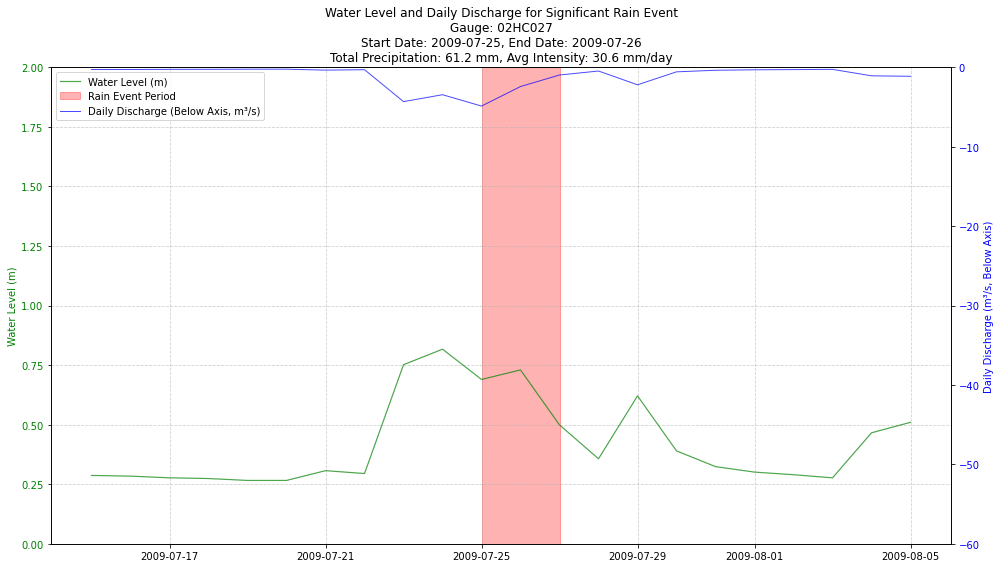

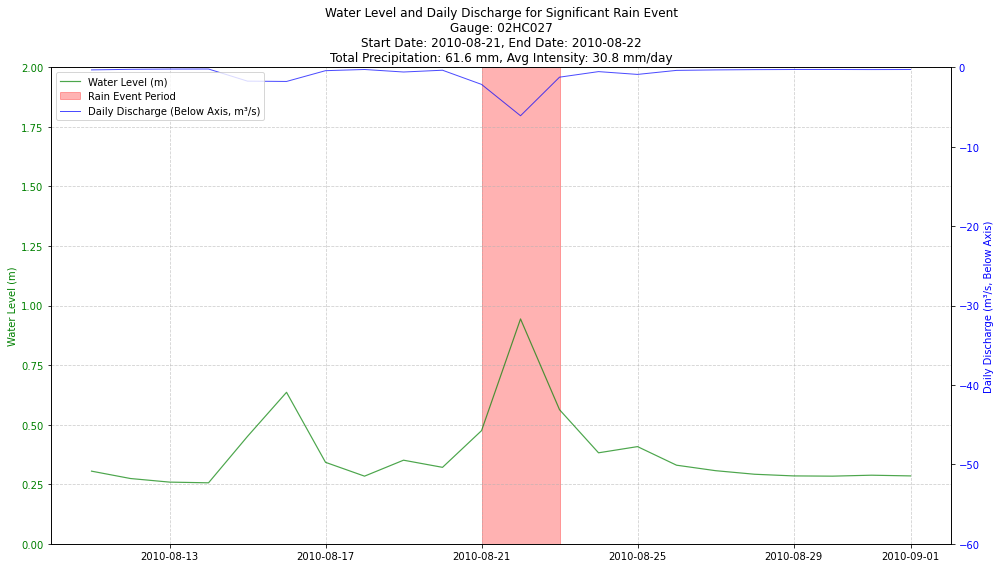

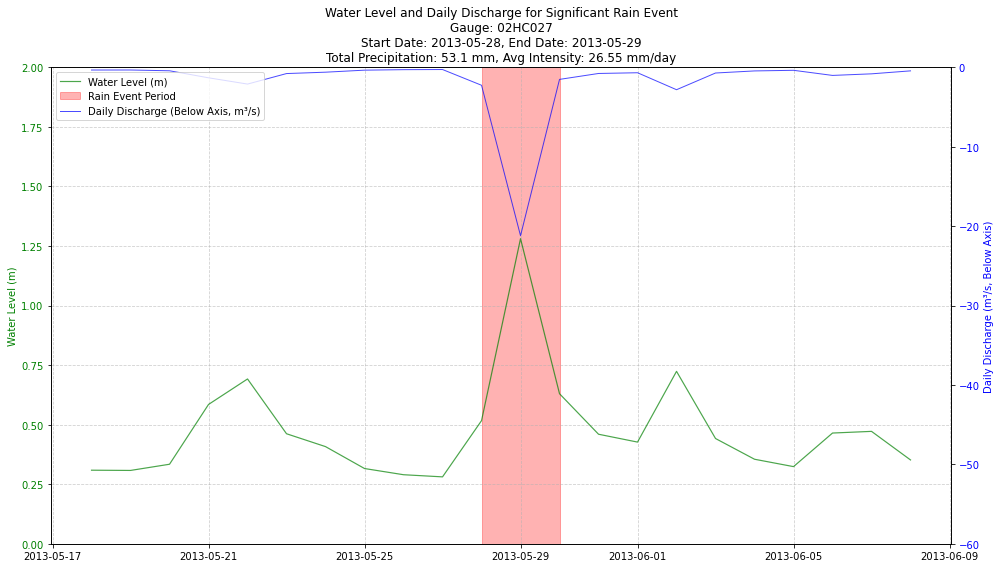

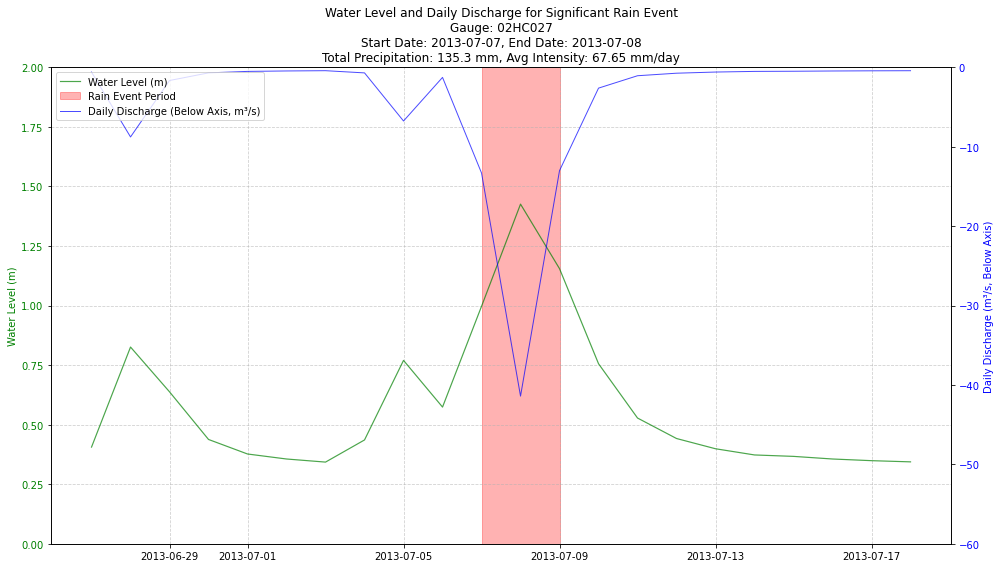

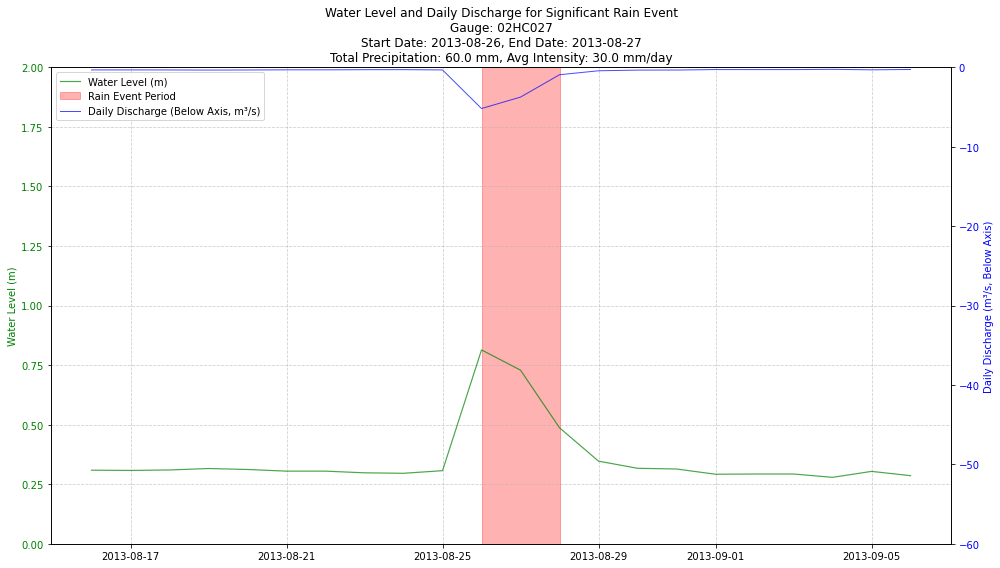

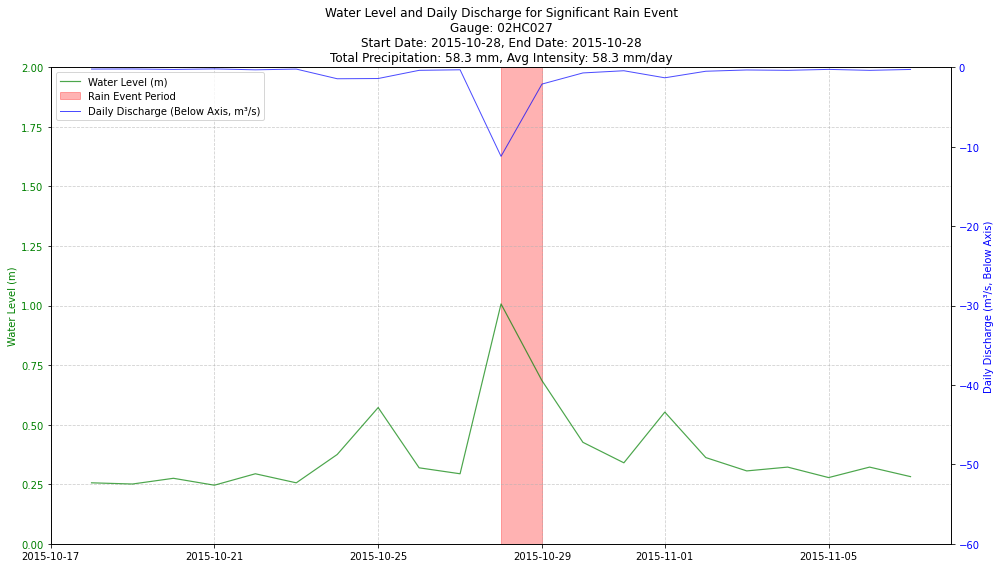

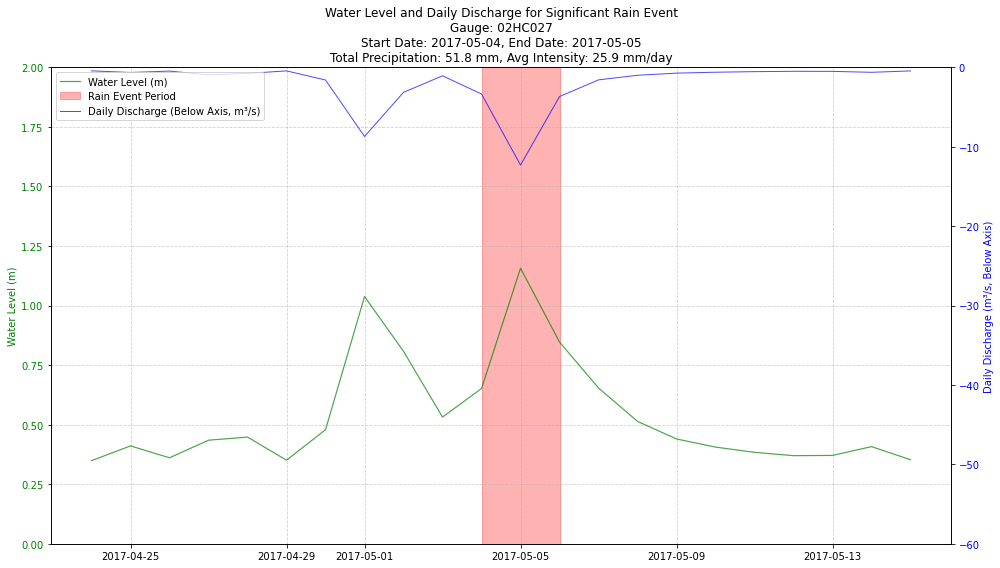

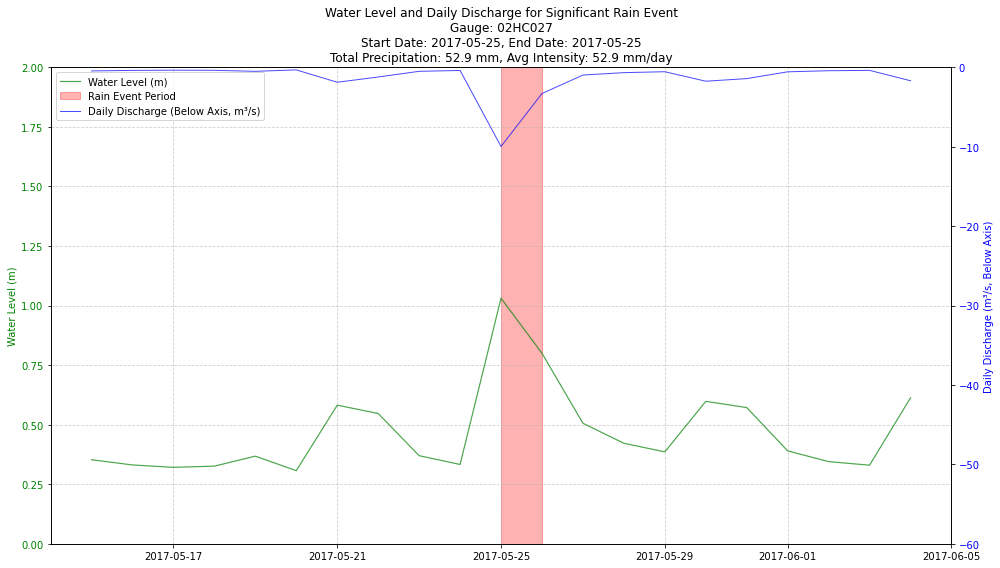

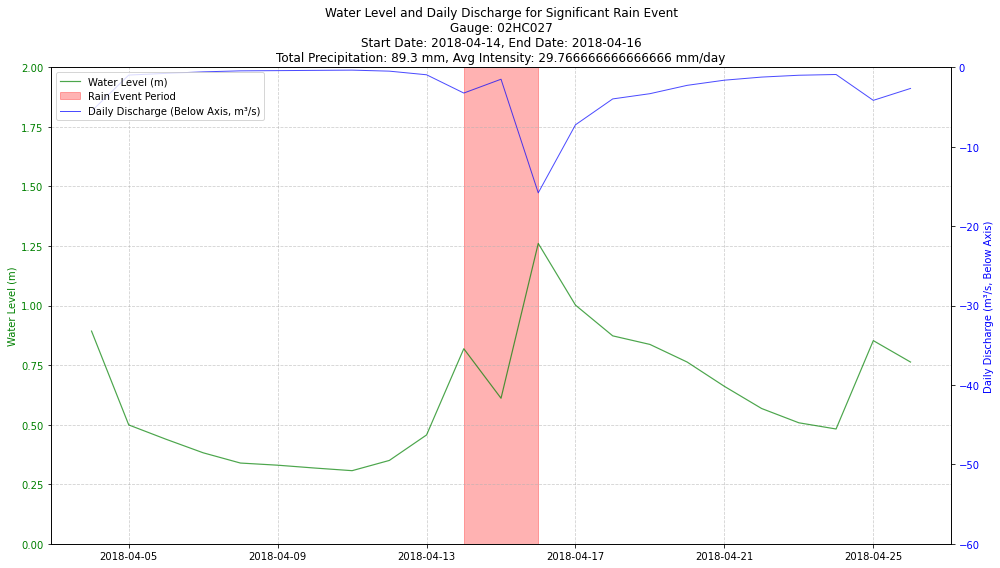

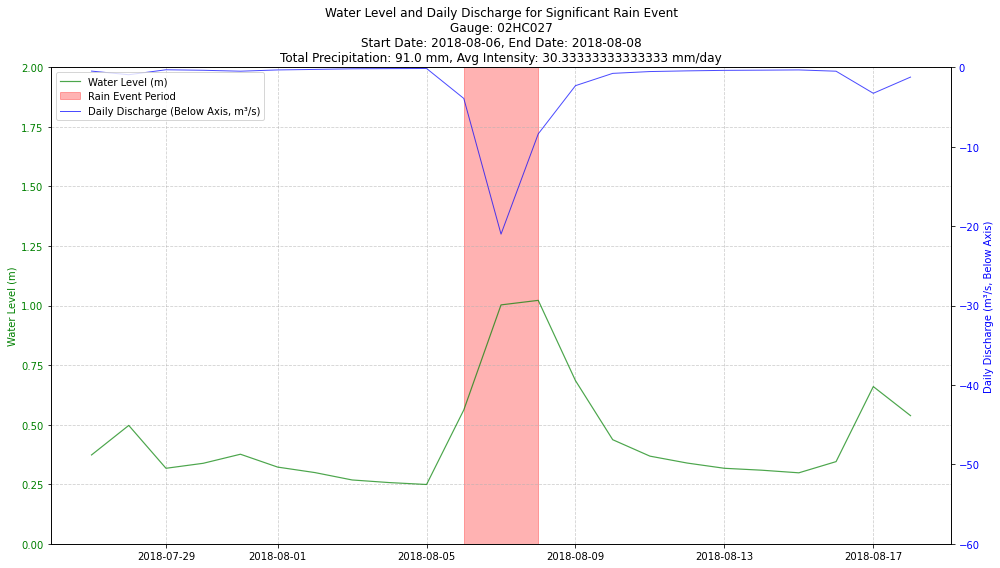

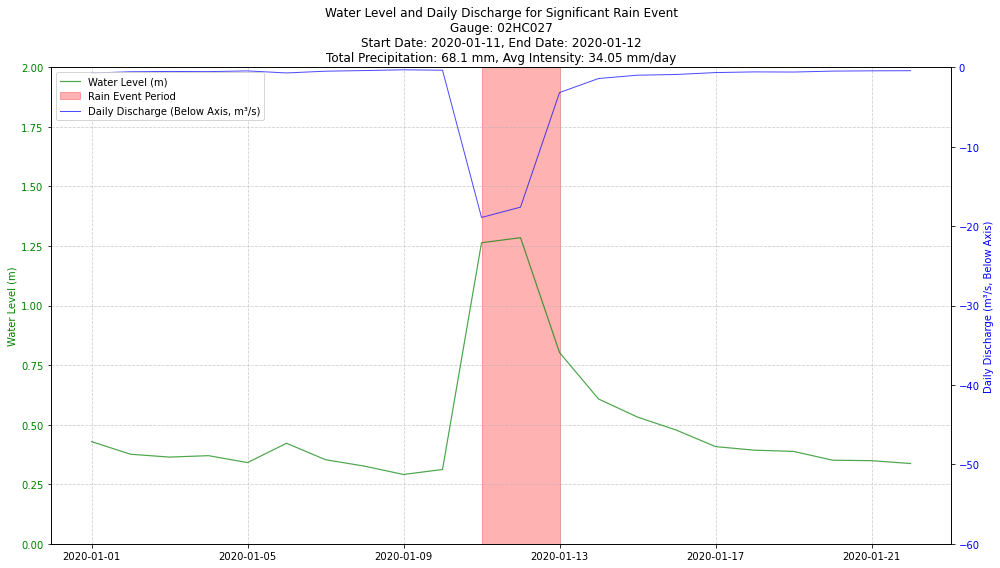

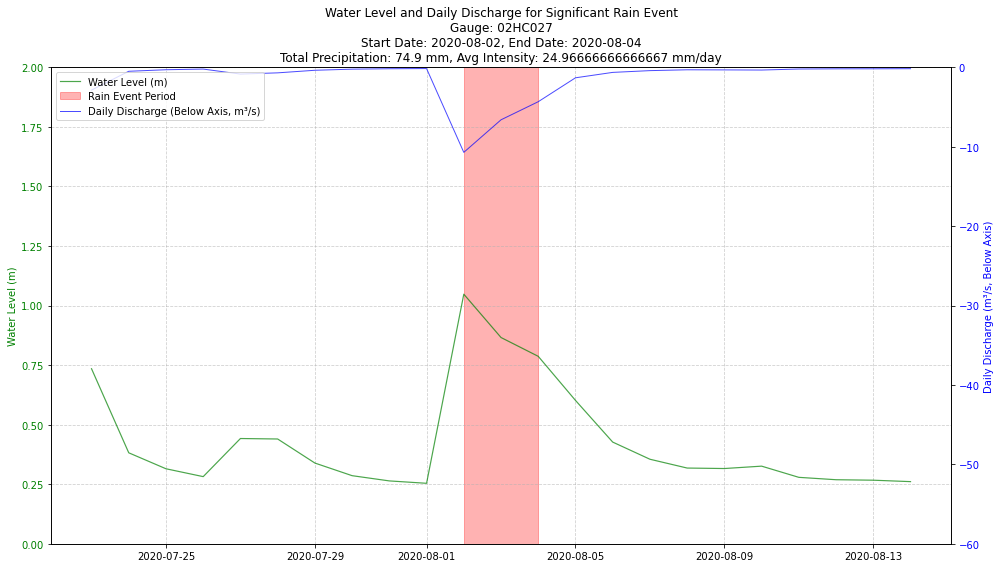

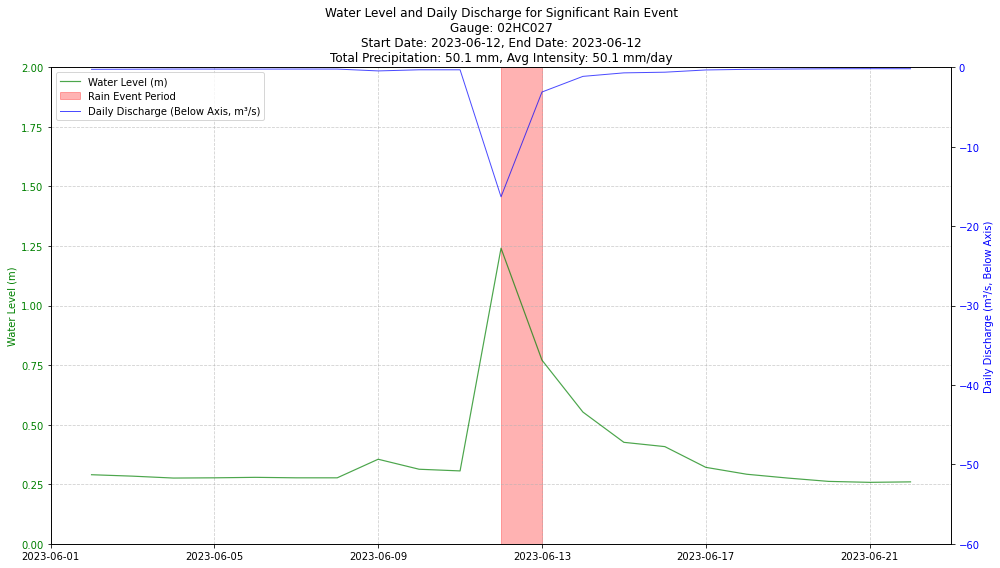

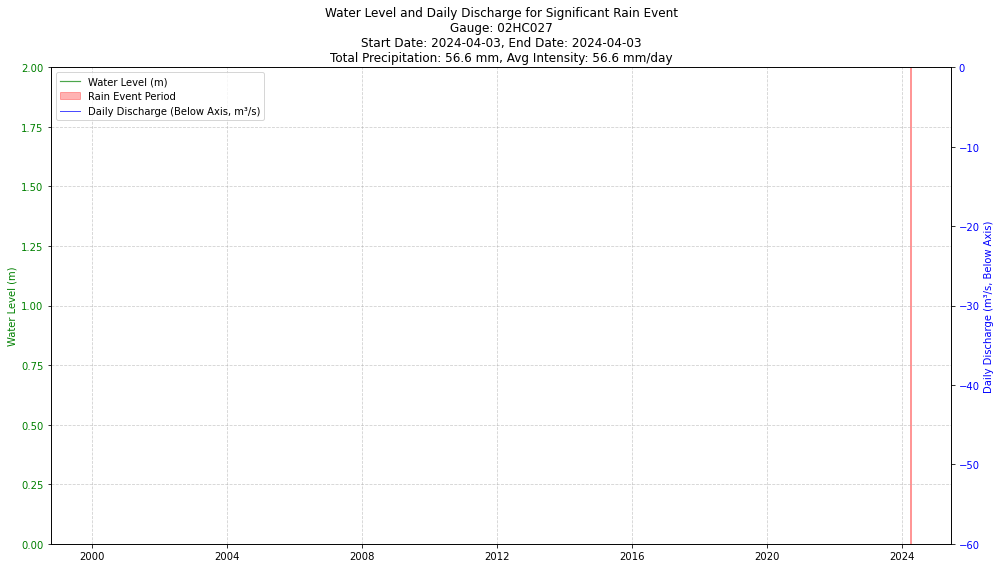

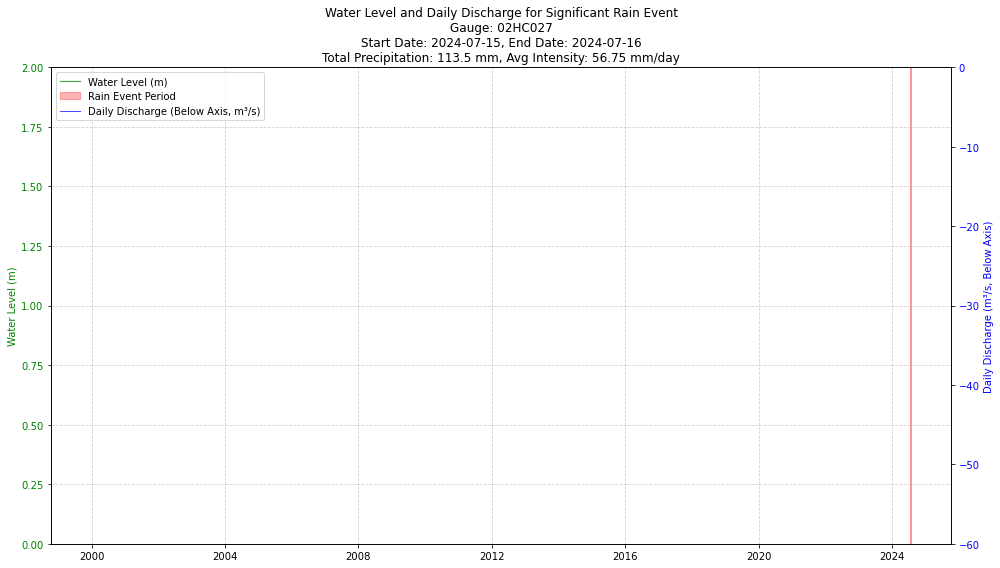

In [27]:
# Plot for Gauge 02HC027
plot_significant_rain_events(
    data=gauge_2_data,
    rain_events=significant_rain_events,
    gauge_id="02HC027",
    water_level_ylim=(0, 2),
    discharge_ylim=(-60, 0)
)


### Now we would want to analyze/compare water level and precipitation for 5 year periods starting from 2002

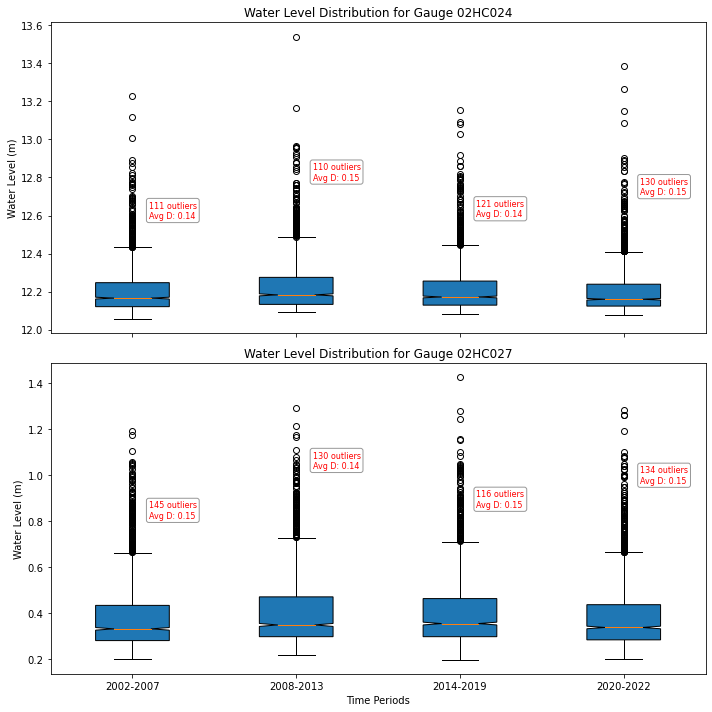

In [28]:
# Define the 5-year periods
time_periods = [
    ("2003-01-01", "2007-12-31"),
    ("2008-01-01", "2012-12-31"),
    ("2013-01-01", "2017-12-31"),
    ("2018-01-01", "2022-12-31"),
]

# Function to filter data into time periods
def get_time_period_data(data, time_periods):
    period_data = []
    outlier_info = []  # Store information about outliers for each period
    for start, end in time_periods:
        period_df = data[(data["Date"] >= start) & (data["Date"] <= end)]
        if not period_df.empty:
            water_levels = period_df["water_level"].dropna().values  # Drop NaN values
            # Calculate upper bound for outlier detection
            q3 = np.percentile(water_levels, 75)
            iqr = q3 - np.percentile(water_levels, 25)
            upper_bound = q3 + 1.5 * iqr
            outliers = water_levels[water_levels > upper_bound]
            outlier_info.append({"upper_bound": upper_bound, "outliers": outliers})
            period_data.append(water_levels)
        else:
            outlier_info.append({"upper_bound": None, "outliers": []})
            period_data.append([])  
    return period_data, outlier_info

# Separate data by gauge ID
gauge_ids = flow_data_merged["ID"].unique()
fig, axes = plt.subplots(nrows=len(gauge_ids), ncols=1, figsize=(10, 10), sharex=True)

for ax, gauge_id in zip(axes, gauge_ids):
    # Filter data for this gauge
    gauge_data = flow_data_merged[flow_data_merged["ID"] == gauge_id]
    
    # Get water level data for each time period and outlier information
    time_period_data, outlier_info = get_time_period_data(gauge_data, time_periods)
    
    # Check if all data is empty for this gauge
    if all(len(period) == 0 for period in time_period_data):
        ax.text(0.5, 0.5, f"No data available for Gauge {gauge_id}", ha="center", va="center")
        ax.set_title(f"Water Level Distribution for Gauge {gauge_id}")
        ax.set_ylabel("Water Level (m)")
        continue
    
    # Create boxplot
    box = ax.boxplot(time_period_data, patch_artist=True, notch=True)
    ax.set_title(f"Water Level Distribution for Gauge {gauge_id}")
    ax.set_ylabel("Water Level (m)")
    ax.set_xticks(range(1, len(time_periods) + 1))
    ax.set_xticklabels(["2002-2007", "2008-2013", "2014-2019", "2020-2022"])
    
    # Adjust outlier annotation
    for i, info in enumerate(outlier_info):
        if info["outliers"].size > 0:
            # Offset annotation to prevent overlap
            x_offset = 0.1  # Move annotation  to the right
            y_offset = 0.15 * (i % 2 + 1)  # Alternate offsets for better clarity
            ax.annotate(
                f"{len(info['outliers'])} outliers\nAvg D: {np.mean(info['outliers'] - info['upper_bound']):.2f}",
                xy=(i + 1, info["upper_bound"]),
                xytext=(i + 1 + x_offset, info["upper_bound"] + y_offset),  # Move right and above
                textcoords="data",
                ha="left",  # Align left for better readability
                fontsize=8,
                color="red",
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8),
            )

# Set shared x-axis label
axes[-1].set_xlabel("Time Periods")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### We will also analyze precipitation data below

In [29]:
climate_data = pd.read_csv("processed_climate_data.csv")
climate_data["LOCAL_DATE"] = pd.to_datetime(climate_data["LOCAL_DATE"])
climate_data.head()

LOCAL_DATE  MEAN_TEMPERATURE  TOTAL_PRECIPITATION
0 2002-06-04              11.6                  4.8
1 2002-06-05              17.4                  3.4
2 2002-06-06              15.3                  0.0
3 2002-06-07              16.2                  0.0
4 2002-06-08              18.3                  0.0

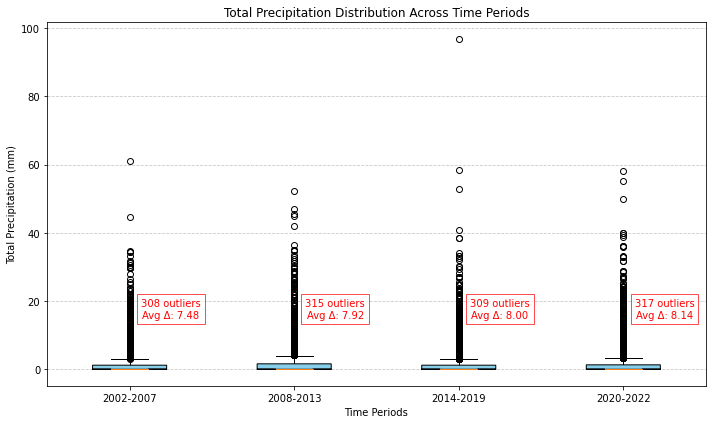

In [30]:
# Define 5-year periods
time_periods = [
    ("2003-01-01", "2007-12-31"),
    ("2008-01-01", "2012-12-31"),
    ("2013-01-01", "2017-12-31"),
    ("2018-01-01", "2022-12-31"),
]

# Function to filter data into time periods
def get_precipitation_data(data, time_periods):
    period_data = []
    for start, end in time_periods:
        period_df = data[(data["LOCAL_DATE"] >= start) & (data["LOCAL_DATE"] <= end)]
        if not period_df.empty:
            period_data.append(period_df["TOTAL_PRECIPITATION"].dropna().values)  # Drop NaN values
        else:
            period_data.append([])  
    return period_data

# Get total precipitation data for each time period
precipitation_data = get_precipitation_data(climate_data, time_periods)

# Calculate Outliers for each time period
outlier_stats = []
for period in precipitation_data:
    if len(period) > 0:
        q1 = np.percentile(period, 25)
        q3 = np.percentile(period, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = period[(period < lower_bound) | (period > upper_bound)]
        avg_deviation = np.mean(outliers - upper_bound) if len(outliers) > 0 else 0
        outlier_stats.append((len(outliers), avg_deviation))
    else:
        outlier_stats.append((0, 0))

# Create Boxplots
plt.figure(figsize=(10, 6))
box = plt.boxplot(precipitation_data, patch_artist=True, notch=True)

# Style the boxplots
for patch in box['boxes']:
    patch.set_facecolor("skyblue")

# Annotate the number of outliers and average deviation
for i, (outliers_count, avg_deviation) in enumerate(outlier_stats, start=1):
    if outliers_count > 0:
        plt.text(
            i + 0.25,  # Shift to the right
            box["caps"][2 * (i - 1)].get_ydata()[1] + 15,  # Position above the upper cap
            f"{outliers_count} outliers\nAvg Δ: {avg_deviation:.2f}",
            color="red",
            ha="center",
            fontsize=10,
            bbox=dict(facecolor="white", edgecolor="red", alpha=0.7),
        )

# Set plot details
plt.title("Total Precipitation Distribution Across Time Periods")
plt.ylabel("Total Precipitation (mm)")
plt.xlabel("Time Periods")
plt.xticks(range(1, len(time_periods) + 1), ["2002-2007", "2008-2013", "2014-2019", "2020-2022"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


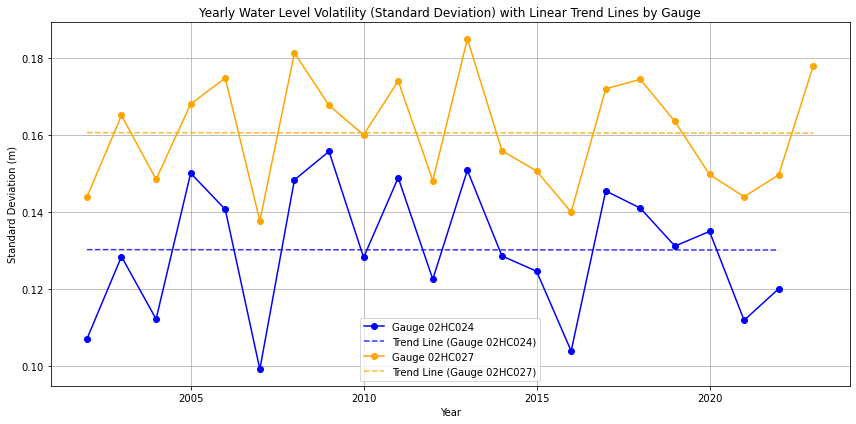

In [ ]:
# Calculate standard deviation of water level for each year, grouped by gauge
std_by_year = flow_data_merged.groupby(["ID", "Year"])["water_level"].std().reset_index()

std_by_year.columns = ["Gauge ID", "Year", "Std Dev Water Level"]

plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red']  

for idx, gauge in enumerate(std_by_year["Gauge ID"].unique()):
    # Filter data for the current gauge
    gauge_data = std_by_year[std_by_year["Gauge ID"] == gauge]
    
    # Plot the standard deviation for each year
    plt.plot(
        gauge_data["Year"],
        gauge_data["Std Dev Water Level"],
        marker="o",
        label=f"Gauge {gauge}",
        color=colors[idx % len(colors)],
    )
    
    # Fit a linear trend line
    z = np.polyfit(gauge_data["Year"], gauge_data["Std Dev Water Level"], 1)  
    p = np.poly1d(z)
    trend_line = p(gauge_data["Year"])
    
    # Plot the linear trend line
    plt.plot(
        gauge_data["Year"],
        trend_line,
        linestyle="--",
        color=colors[idx % len(colors)],
        label=f"Trend Line (Gauge {gauge})",
        alpha=0.8,
    )

# Add plot title and labels
plt.title("Yearly Water Level Volatility (Standard Deviation) with Linear Trend Lines by Gauge")
plt.xlabel("Year")
plt.ylabel("Standard Deviation (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


  Gauge ID Time Period  Std Dev Water Level
0  02HC024   2002-2007             0.125739
1  02HC027   2002-2007             0.157886
2  02HC024   2008-2013             0.144138
3  02HC027   2008-2013             0.172000
4  02HC024   2014-2019             0.131205
5  02HC027   2014-2019             0.161261
6  02HC024   2020-2022             0.122894
7  02HC027   2020-2022             0.148210


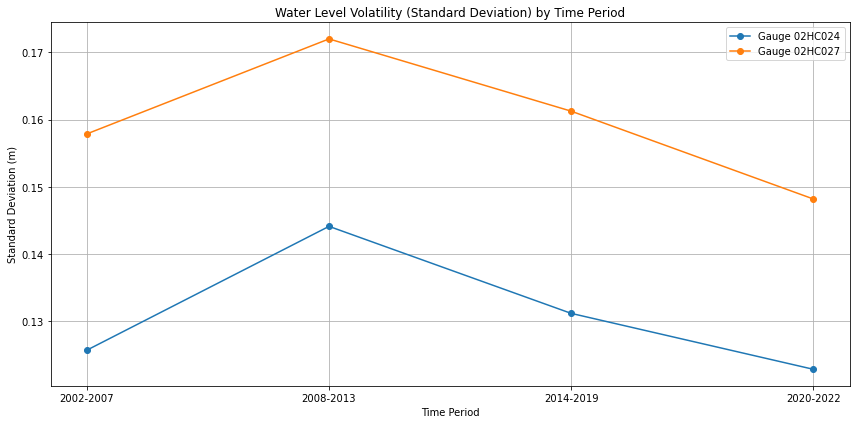

In [ ]:
# Define time periods for grouping
time_periods = [
    ("2002-01-01", "2007-12-31"),
    ("2008-01-01", "2013-12-31"),
    ("2014-01-01", "2019-12-31"),
    ("2020-01-01", "2022-12-31"),
]

# Function to calculate standard deviation for grouped periods
def std_by_time_period(data, time_periods):
    results = []
    for start, end in time_periods:
        period_data = data[(data["Date"] >= start) & (data["Date"] <= end)]
        std_dev = period_data.groupby("ID")["water_level"].std()
        results.append(pd.DataFrame({
            "Gauge ID": std_dev.index,
            "Time Period": f"{start[:4]}-{end[:4]}",
            "Std Dev Water Level": std_dev.values,
        }))
    return pd.concat(results, ignore_index=True)

std_by_period = std_by_time_period(flow_data_merged, time_periods)

print(std_by_period)

plt.figure(figsize=(12, 6))
for gauge in std_by_period["Gauge ID"].unique():
    gauge_data = std_by_period[std_by_period["Gauge ID"] == gauge]
    plt.plot(
        gauge_data["Time Period"],
        gauge_data["Std Dev Water Level"],
        marker="o",
        label=f"Gauge {gauge}",
    )

plt.title("Water Level Volatility (Standard Deviation) by Time Period")
plt.xlabel("Time Period")
plt.ylabel("Standard Deviation (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
# Create separate DataFrames for PARAM = 1 and PARAM = 2 
param_1_data = flow_data[flow_data["PARAM"] == 1][["ID", "Date", "Value"]].rename(columns={"Value": "daily_discharge"})
param_2_data = flow_data[flow_data["PARAM"] == 2][["ID", "Date", "Value"]].rename(columns={"Value": "water_level"})

# Merge the two DataFrames on ID and Date
flow_data_merged_new = pd.merge(param_1_data, param_2_data, on=["ID", "Date"], how="outer")

# Verify the merged DataFrame
print(flow_data_merged_new) # Create a new flow_data_merged dataframe to include data from 1966 for further analysis

            ID        Date  daily_discharge  water_level
0      02HC027  1966/07/04            0.357          NaN
1      02HC027  1966/07/05            0.249          NaN
2      02HC027  1966/07/06            0.275          NaN
3      02HC027  1966/07/07            0.337          NaN
4      02HC027  1966/07/08            0.252          NaN
...        ...         ...              ...          ...
43002  02HC024  2022/12/27            2.280       12.141
43003  02HC024  2022/12/28            2.150       12.134
43004  02HC024  2022/12/29            2.490       12.151
43005  02HC024  2022/12/30            4.920       12.249
43006  02HC024  2022/12/31           26.400       12.767

[43007 rows x 4 columns]


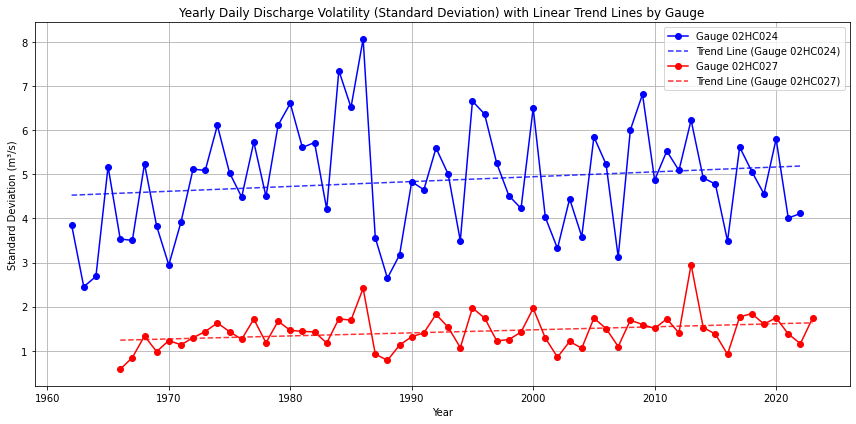

In [50]:

flow_data_merged_new["Year"] = pd.to_datetime(flow_data_merged_new["Date"]).dt.year

# Calculate standard deviation of daily discharge for each year, grouped by gauge
std_by_year_discharge = flow_data_merged_new.groupby(["ID", "Year"])["daily_discharge"].std().reset_index()

std_by_year_discharge.columns = ["Gauge ID", "Year", "Std Dev Daily Discharge"]

plt.figure(figsize=(12, 6))
colors = ['blue', 'red', 'orange', 'green']  

for idx, gauge in enumerate(std_by_year_discharge["Gauge ID"].unique()):
    # Filter data for the current gauge
    gauge_data = std_by_year_discharge[std_by_year_discharge["Gauge ID"] == gauge]
    
    # Plot the standard deviation for each year
    plt.plot(
        gauge_data["Year"],
        gauge_data["Std Dev Daily Discharge"],
        marker="o",
        label=f"Gauge {gauge}",
        color=colors[idx % len(colors)],
    )
    
    # Fit a linear trend line
    z = np.polyfit(gauge_data["Year"], gauge_data["Std Dev Daily Discharge"], 1)  
    p = np.poly1d(z)
    trend_line = p(gauge_data["Year"])
    
    # Plot the linear trend line
    plt.plot(
        gauge_data["Year"],
        trend_line,
        linestyle="--",
        color=colors[idx % len(colors)],
        label=f"Trend Line (Gauge {gauge})",
        alpha=0.8,
    )

plt.title("Yearly Daily Discharge Volatility (Standard Deviation) with Linear Trend Lines by Gauge")
plt.xlabel("Year")
plt.ylabel("Standard Deviation (m³/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
